In [1]:
import sys, os
if 'google.colab' in sys.modules:
    # mount google drive
    from google.colab import drive
    drive.mount('/content/gdrive')
    # specify the path of the folder containing "file_name" :
    path_to_file = '/content/gdrive/My Drive/5153: Applied Machine Learning/LSTM Data/'
    print(path_to_file)
    # change current path to the folder containing "file_name"
    os.chdir(path_to_file)
    !pwd

Mounted at /content/gdrive
/content/gdrive/My Drive/5153: Applied Machine Learning/LSTM Data/
/content/gdrive/My Drive/5153: Applied Machine Learning/LSTM Data


In [2]:
import pandas as pd
import numpy as np
import datetime
from datetime import date, timedelta
import seaborn as sns
import matplotlib.pyplot as plt

import tensorflow as tf
tf.random.set_seed(221)

from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from tensorflow.keras.models import load_model
import math
import prediction_prep as prep

import warnings
warnings.filterwarnings('ignore')

## Load in Data

In [3]:
# READ IN ALL DATA
ticker = 'WISH'
comments = pd.read_csv('comments_preprocessed_assigned.csv')
sentiment = pd.read_csv('df_pred_id_body.csv')
# fin_data = pd.read_csv(r'C:\Users\Nylle\`Assignments\LSTM\Stock\AMC_2021.csv')
fin_data = pd.read_csv('stock_data/{}_2021.csv'.format(ticker))

# Call custom function to get concatenated df with all features
df = prep.get_regression_df(ticker_name = str.lower(ticker),
                           comments = comments, 
                           fin_data = fin_data,
                           sentiment = sentiment)

# Set up a results dictionary object
results_dict = {}

df.head()

,date,comments_neutral,comments_positive,comment_count,pct_pos_comments,is_meme,comments_neutral_rollsum_2D,comments_neutral_rollmean_2D,comments_neutral_2D_pctchg,comments_positive_rollsum_2D,...,Dir,2Dir,3Dir,4Dir,5Dir,6Dir,7Dir,SD,day_of_week,SD_log
0,2021-01-01,1.0,0.0,1.0,0.0,0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4,NaN
1,2021-01-02,1.0,0.0,1.0,0.0,0,2.0,1.0,NaN,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5,NaN
2,2021-01-03,0.0,0.0,0.0,0.0,0,1.0,0.5,-100.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6,NaN
3,2021-01-04,0.0,0.0,0.0,0.0,0,0.0,0.0,-100.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.802100,0,0.588953
4,2021-01-05,1.0,0.0,1.0,0.0,0,1.0,0.5,100.0,0.0,...,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.081353,1,0.078213


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 366 entries, 0 to 365
Data columns (total 100 columns):
 #   Column                         Non-Null Count  Dtype         
---  ------                         --------------  -----         
 0   date                           366 non-null    datetime64[ns]
 1   comments_neutral               366 non-null    float64       
 2   comments_positive              366 non-null    float64       
 3   comment_count                  366 non-null    float64       
 4   pct_pos_comments               366 non-null    float64       
 5   is_meme                        366 non-null    int64         
 6   comments_neutral_rollsum_2D    365 non-null    float64       
 7   comments_neutral_rollmean_2D   365 non-null    float64       
 8   comments_neutral_2D_pctchg     342 non-null    float64       
 9   comments_positive_rollsum_2D   365 non-null    float64       
 10  comments_positive_rollmean_2D  365 non-null    float64       
 11  comments_positive_

## LSTM: CLOSE PRICE WITH SENTIMENT

### 1-Day Shift

In [5]:
## DAILY%CHANGE ##
dep_var = ['Close'] 
other_var = ['day_of_week']
sentiment_vars = [i for i in df.columns if 'comment' in i] +['is_meme']
fin_vars = list(set(df.columns) - set(dep_var+other_var+sentiment_vars+['date'])) # catch all
print('Check that these are all just independent financial vars: '+str(fin_vars))
shift = 1

pred_lag = prep.lag_pred_df(df = df,
                       dep_var = dep_var,
                       other_var = other_var, 
                       fin_vars = fin_vars, 
                       sentiment_vars = sentiment_vars, 
                       shift = shift)

pred_lag = pred_lag.dropna()
pred_lag.head()

Check that these are all just independent financial vars: ['2D%Change', '7Dir', 'Volume', 'Dir', '6Dir', '5D%Change', 'SD', 'SD_log', '3Dir', 'Open', 'High', 'Daily%Change', '6D%Change', '7D%Change', '4Dir', '5Dir', '3D%Change', '4D%Change', 'Low', '2Dir']
Length of dataframe before dropping weekends: 366
Length of dataframe after dropping weekends: 250


,Close,day_of_week,comments_neutral(t-1),comments_positive(t-1),comment_count(t-1),pct_pos_comments(t-1),comments_neutral_rollsum_2D(t-1),comments_neutral_rollmean_2D(t-1),comments_neutral_2D_pctchg(t-1),comments_positive_rollsum_2D(t-1),...,Daily%Change(t-1),6D%Change(t-1),7D%Change(t-1),4Dir(t-1),5Dir(t-1),3D%Change(t-1),4D%Change(t-1),Low(t-1),2Dir(t-1),Close(t-1)
7,23.920000,2,148.0,38.0,186.0,20.430097,152.0,76.0,1133.333333,38.0,...,6.782253,8.835763,14.802636,1.0,1.0,0.047779,0.576373,19.799999,1.0,20.940001
8,28.129999,3,84.0,31.0,115.0,26.956498,232.0,116.0,2000.000000,69.0,...,14.231134,20.808086,24.324326,1.0,1.0,17.485262,14.285713,20.900000,1.0,23.920000
9,24.834999,4,8.0,10.0,18.0,55.555247,92.0,46.0,-94.594595,41.0,...,17.600331,35.110469,42.070708,1.0,1.0,43.447212,38.163057,23.780001,1.0,28.129999
10,26.090000,1,5.0,1.0,6.0,16.666389,7.0,3.5,-44.444444,5.0,...,-11.713474,18.657423,19.284339,1.0,1.0,18.600757,26.644560,24.400000,1.0,24.834999
11,25.850000,2,9.0,4.0,13.0,30.768994,14.0,7.0,350.000000,5.0,...,5.053357,28.143415,24.653606,1.0,1.0,9.071907,24.594076,25.000000,0.0,26.090000


In [6]:
# List of considered Features
FEATURES = pred_lag.columns

print('FEATURE LIST')
print([f for f in FEATURES])

# Create the dataset with features and filter the data to the list of FEATURES
data = pred_lag
data_filtered = data[FEATURES]

# We add a prediction column and set dummy values to prepare the data for scaling
data_filtered_ext = data_filtered.copy()
# data_filtered_ext['Prediction'] = data_filtered_ext[dep_var[0]]
#data_filtered_ext.drop(dep_var, axis = 1, inplace = True)

# Print the tail of the dataframe
data_filtered_ext.tail()

FEATURE LIST
['Close', 'day_of_week', 'comments_neutral(t-1)', 'comments_positive(t-1)', 'comment_count(t-1)', 'pct_pos_comments(t-1)', 'comments_neutral_rollsum_2D(t-1)', 'comments_neutral_rollmean_2D(t-1)', 'comments_neutral_2D_pctchg(t-1)', 'comments_positive_rollsum_2D(t-1)', 'comments_positive_rollmean_2D(t-1)', 'comments_positive_2D_pctchg(t-1)', 'comment_count_rollsum_2D(t-1)', 'comment_count_rollmean_2D(t-1)', 'comment_count_2D_pctchg(t-1)', 'pct_pos_comments_rollsum_2D(t-1)', 'pct_pos_comments_rollmean_2D(t-1)', 'pct_pos_comments_2D_pctchg(t-1)', 'comments_neutral_rollsum_3D(t-1)', 'comments_neutral_rollmean_3D(t-1)', 'comments_neutral_3D_pctchg(t-1)', 'comments_positive_rollsum_3D(t-1)', 'comments_positive_rollmean_3D(t-1)', 'comments_positive_3D_pctchg(t-1)', 'comment_count_rollsum_3D(t-1)', 'comment_count_rollmean_3D(t-1)', 'comment_count_3D_pctchg(t-1)', 'pct_pos_comments_rollsum_3D(t-1)', 'pct_pos_comments_rollmean_3D(t-1)', 'pct_pos_comments_3D_pctchg(t-1)', 'comments_ne

,Close,day_of_week,comments_neutral(t-1),comments_positive(t-1),comment_count(t-1),pct_pos_comments(t-1),comments_neutral_rollsum_2D(t-1),comments_neutral_rollmean_2D(t-1),comments_neutral_2D_pctchg(t-1),comments_positive_rollsum_2D(t-1),...,Daily%Change(t-1),6D%Change(t-1),7D%Change(t-1),4Dir(t-1),5Dir(t-1),3D%Change(t-1),4D%Change(t-1),Low(t-1),2Dir(t-1),Close(t-1)
234,3.74,1,6.0,2.0,8.0,24.999688,8.0,4.0,-76.000000,3.0,...,10.060973,-7.908168,-9.068013,0.0,0.0,7.761194,-3.217161,3.11,1.0,3.61
235,3.78,2,9.0,2.0,11.0,18.181653,15.0,7.5,350.000000,4.0,...,3.601111,-5.555556,-4.591838,1.0,1.0,11.309528,11.641795,3.60,1.0,3.74
236,3.60,3,133.0,29.0,162.0,17.901224,142.0,71.0,2116.666667,31.0,...,1.069518,1.340481,-4.545456,1.0,1.0,15.243903,12.500003,3.63,1.0,3.78
237,3.58,4,16.0,5.0,21.0,23.809410,149.0,74.5,77.777778,34.0,...,-4.761907,7.462687,-3.485258,1.0,1.0,-0.277008,9.756096,3.60,0.0,3.60
238,3.41,0,0.0,0.0,0.0,0.000000,0.0,0.0,-100.000000,0.0,...,-0.555555,6.547620,6.865672,0.0,1.0,-4.278077,-0.831024,3.49,0.0,3.58


In [7]:
# Set the sequence length - this is the timeframe used to make a single prediction
sequence_length = 7

# Prediction Index
index_Close = data.columns.get_loc(dep_var[0])

# Split the training data into train and train data sets
# As a first step, we get the number of rows to train the model on 80% of the data 
train_data_len = math.ceil(data_filtered_ext.shape[0] * 0.8)

# Create the training and test data first
train_data = data_filtered.iloc[0:train_data_len] # DATA_FILTERED USED FOR PREDICTION
test_data = data_filtered.iloc[train_data_len - sequence_length:]

# Transform the data by scaling each feature to a range between 0 and 1
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
train_data = scaler.fit_transform(train_data)
test_data = scaler.transform(test_data)

# Convert the data to numpy values
nrows = train_data.shape[0]
train_data = np.array(train_data)
train_data = np.reshape(train_data, (nrows, -1))
print(train_data.shape)


# Convert the data to numpy values
nrows = test_data.shape[0]
test_data = np.array(test_data)
test_data = np.reshape(test_data, (nrows, -1))
print(test_data.shape)

# Creating a separate scaler that works on a single column for scaling predictions
scaler_pred = MinMaxScaler()
df_Close = pd.DataFrame(data_filtered_ext[dep_var[0]][0:train_data_len])
np_Close_scaled = scaler_pred.fit_transform(df_Close)


(162, 100)
(47, 100)


In [8]:
# The RNN needs data with the format of [samples, time steps, features]
# Here, we create N samples, sequence_length time steps per sample, and 6 features
def partition_dataset(sequence_length, data):
    x, y = [], []
    data_len = data.shape[0]
    for i in range(sequence_length, data_len):
        x.append(data[i-sequence_length:i,1:data.shape[1]+1]) #contains sequence_length values 0-sequence_length * columsn
        y.append(data[i, index_Close]) #contains the prediction values for validation,  for single-step prediction
    
    # Convert the x and y to numpy arrays
    x = np.array(x)
    y = np.array(y)
    return x, y

# Generate training data and test data
x_train, y_train = partition_dataset(sequence_length, train_data)
x_test, y_test = partition_dataset(sequence_length, test_data)

# Print the shapes: the result is: (rows, training_sequence, features) (prediction value, )
print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

# Validate that the prediction value and the input match up
# The last close price of the second input sample should equal the first prediction value
print(x_train[1][sequence_length-1][index_Close])
print(y_train[0])

(155, 7, 99) (155,)
(40, 7, 99) (40,)
0.0
0.7902309410257526


In [9]:
# Configure the neural network model
model = Sequential()

# Model with n_neurons = inputshape Timestamps, each with x_train.shape[2] variables
n_neurons = x_train.shape[1] * x_train.shape[2]
print(n_neurons, x_train.shape[1], x_train.shape[2])
model.add(LSTM(n_neurons, return_sequences=True, input_shape=(x_train.shape[1], x_train.shape[2]))) 
model.add(LSTM(n_neurons, return_sequences=False))
model.add(Dense(5))
model.add(Dense(1))

# Compile the model
model.compile(optimizer='adam', loss='mse')

693 7 99


In [10]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
path = '{}_{}_{}shift_Sentiment.h5'.format(ticker, dep_var[0], shift)
# Training the model
epochs = 100
batch_size = 16
early_stop = EarlyStopping(monitor='val_loss', patience=5, verbose=1)
mc = ModelCheckpoint(filepath = path ,monitor='val_loss',save_best_only=True, mode = 'min',verbose=1)
history = model.fit(x_train, y_train, 
                    batch_size=batch_size, 
                    epochs=epochs,
                    validation_data=(x_test, y_test),
                    callbacks = [early_stop,mc]
                   )

Epoch 1/100
10/10 [==============================] - ETA: 0s - loss: 0.1980
Epoch 1: val_loss improved from inf to 0.04202, saving model to WISH_Close_1shift_Sentiment.h5
10/10 [==============================] - 8s 392ms/step - loss: 0.1980 - val_loss: 0.0420
Epoch 2/100
10/10 [==============================] - ETA: 0s - loss: 0.0137
Epoch 2: val_loss improved from 0.04202 to 0.00172, saving model to WISH_Close_1shift_Sentiment.h5
10/10 [==============================] - 3s 298ms/step - loss: 0.0137 - val_loss: 0.0017
Epoch 3/100
10/10 [==============================] - ETA: 0s - loss: 0.0077
Epoch 3: val_loss did not improve from 0.00172
10/10 [==============================] - 3s 267ms/step - loss: 0.0077 - val_loss: 0.0056
Epoch 4/100
10/10 [==============================] - ETA: 0s - loss: 0.0048
Epoch 4: val_loss did not improve from 0.00172
10/10 [==============================] - 3s 276ms/step - loss: 0.0048 - val_loss: 0.0076
Epoch 5/100
10/10 [==============================] -

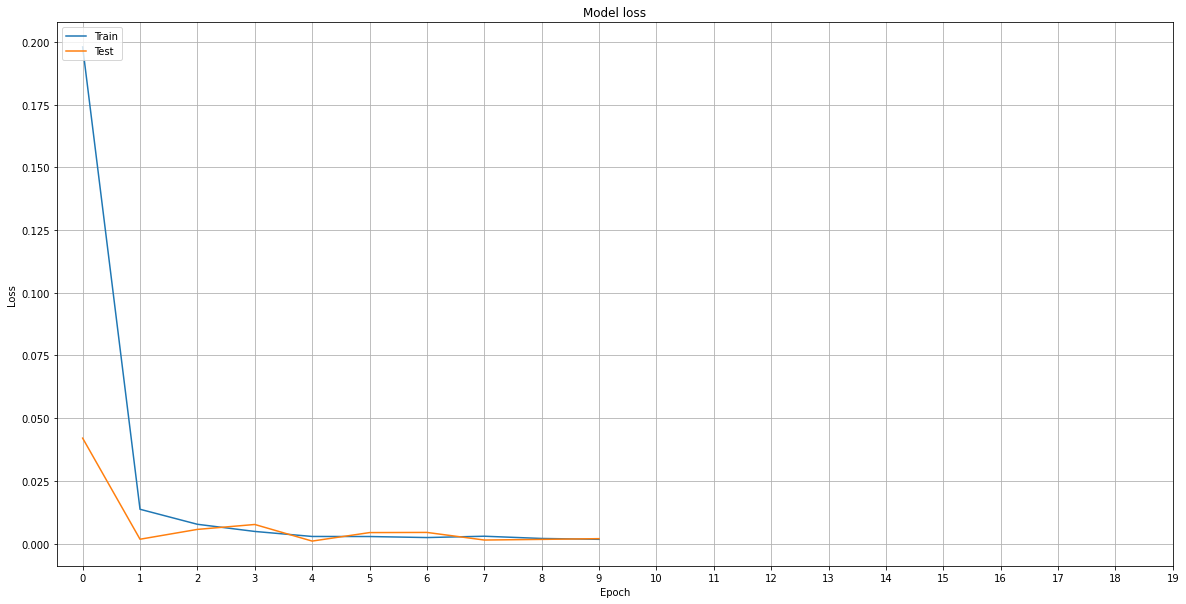

In [11]:
# Plot training & validation loss values
fig, ax = plt.subplots(figsize=(20, 10), sharex=True)
plt.plot(history.history["loss"]) 
plt.plot(history.history["val_loss"])  
plt.title("Model loss")
plt.ylabel("Loss")
plt.xlabel("Epoch")
ax.xaxis.set_major_locator(plt.MaxNLocator(epochs))
plt.xticks(np.arange(20))
plt.legend(["Train", "Test"], loc="upper left")
plt.grid()
plt.show()

In [12]:
MAE_list =[]
MAPE_list=[]
MDAPE_list =[]


# Get the predicted values
model = load_model(path)  ### load model with lowest val_loss
y_pred_scaled = model.predict(x_test)

# Unscale the predicted values
y_pred = scaler_pred.inverse_transform(y_pred_scaled)
y_test_unscaled = scaler_pred.inverse_transform(y_test.reshape(-1, 1))

# Mean Absolute Error (MAE)
MAE = mean_absolute_error(y_test_unscaled, y_pred)
print(f'Median Absolute Error (MAE): {np.round(MAE, 2)}')
MAE_list.append(MAE)

# Mean Absolute Percentage Error (MAPE)
MAPE = np.mean((np.abs(np.subtract(y_test_unscaled, y_pred)/ y_test_unscaled))) * 100
print(f'Mean Absolute Percentage Error (MAPE): {np.round(MAPE, 2)} %')
MAPE_list.append(MAPE)

# Median Absolute Percentage Error (MDAPE)
MDAPE = np.median((np.abs(np.subtract(y_test_unscaled, y_pred)/ y_test_unscaled)) ) * 100
print(f'Median Absolute Percentage Error (MDAPE): {np.round(MDAPE, 2)} %')
MDAPE_list.append(MDAPE)

results = list(zip(MAE_list,MAPE_list, MDAPE_list))
results = pd.DataFrame(results,columns =['MAE','MAPE','MDAPE'])

# Add results to dictionary
results_dict['{}_{}dayshift_MAE'.format(ticker, shift)] = MAE_list
results_dict['{}_{}dayshift_MAPE'.format(ticker, shift)] = MAPE_list
results_dict['{}_{}dayshift_MDAPE'.format(ticker, shift)] = MDAPE_list
results

Median Absolute Error (MAE): 0.57
Mean Absolute Percentage Error (MAPE): 12.11 %
Median Absolute Percentage Error (MDAPE): 9.16 %


,MAE,MAPE,MDAPE
0,0.56604,12.112776,9.162957


In [13]:
# The date from which on the date is displayed
display_start_date = pd.Timestamp('today') - timedelta(days=438) #as of 10 April

# Add the date column
data_filtered_sub = data_filtered.copy()
data_filtered_sub['Date'] = df.date

# Add the difference between the valid and predicted prices
train = data_filtered_sub[:train_data_len + 1]
valid = data_filtered_sub[train_data_len:]
valid.insert(1, "Prediction", y_pred.ravel(), True)
valid.insert(1, "Difference", valid["Prediction"] - valid["Close"], True)
valid['Date'] = pd.to_datetime(valid['Date'])
train['Date'] = pd.to_datetime(train['Date'])

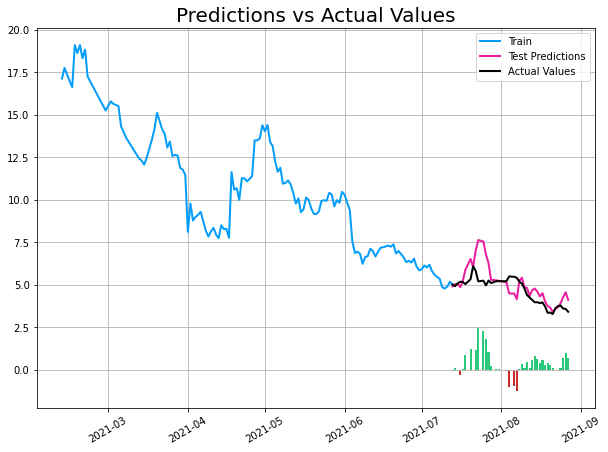

In [14]:
# Zoom in to a closer timeframe
valid = valid[valid['Date'] > display_start_date]
train = train[train['Date'] > display_start_date]

# Visualize the data
fig, ax1 = plt.subplots(figsize=(10, 7), sharex=True)
xt = train['Date']; yt = train[["Close"]]
xv = valid['Date']; yv = valid[["Close", "Prediction"]]
plt.title("Predictions vs Actual Values", fontsize=20)
plt.plot(xt, yt, color="#039dfc", linewidth=2.0)
plt.plot(xv, yv["Prediction"], color="#E91D9E", linewidth=2.0)
plt.plot(xv, yv["Close"], color="black", linewidth=2.0)
plt.legend(["Train", "Test Predictions", "Actual Values"], loc="bottom left")

# # Create the bar plot with the differences
x = valid['Date']
y = valid["Difference"]

# Create custom color range for positive and negative differences
valid.loc[y >= 0, 'diff_color'] = "#2BC97A"
valid.loc[y < 0, 'diff_color'] = "#C92B2B"

plt.bar(x, y, width=0.8, color=valid['diff_color'])
plt.xticks(rotation = 30)

plt.grid()
plt.show()

### 4-Day Shift

In [15]:
## DAILY%CHANGE ##
dep_var = ['Close'] 
other_var = ['day_of_week']
sentiment_vars = [i for i in df.columns if 'comment' in i] +['is_meme']
fin_vars = list(set(df.columns) - set(dep_var+other_var+sentiment_vars+['date'])) # catch all
print('Check that these are all just independent financial vars: '+str(fin_vars))
shift = 4

pred_lag = prep.lag_pred_df(df = df,
                       dep_var = dep_var,
                       other_var = other_var, 
                       fin_vars = fin_vars, 
                       sentiment_vars = sentiment_vars, 
                       shift = shift)

pred_lag = pred_lag.dropna()
pred_lag.head()

Check that these are all just independent financial vars: ['2D%Change', '7Dir', 'Volume', 'Dir', '6Dir', '5D%Change', 'SD', 'SD_log', '3Dir', 'Open', 'High', 'Daily%Change', '6D%Change', '7D%Change', '4Dir', '5Dir', '3D%Change', '4D%Change', 'Low', '2Dir']
Length of dataframe before dropping weekends: 366
Length of dataframe after dropping weekends: 250


,Close,day_of_week,comments_neutral(t-4),comments_positive(t-4),comment_count(t-4),pct_pos_comments(t-4),comments_neutral_rollsum_2D(t-4),comments_neutral_rollmean_2D(t-4),comments_neutral_2D_pctchg(t-4),comments_positive_rollsum_2D(t-4),...,Daily%Change(t-4),6D%Change(t-4),7D%Change(t-4),4Dir(t-4),5Dir(t-4),3D%Change(t-4),4D%Change(t-4),Low(t-4),2Dir(t-4),Close(t-4)
10,26.09,1,16.0,18.0,34.0,52.941021,24.0,12.0,-80.952381,28.0,...,6.782253,8.835763,14.802636,1.0,1.0,0.047779,0.576373,19.799999,1.0,20.940001
11,25.85,2,9.0,9.0,18.0,49.999722,25.0,12.5,12.500000,27.0,...,14.231134,20.808086,24.324326,1.0,1.0,17.485262,14.285713,20.900000,1.0,23.920000
12,24.84,3,2.0,4.0,6.0,66.665556,11.0,5.5,-87.500000,13.0,...,17.600331,35.110469,42.070708,1.0,1.0,43.447212,38.163057,23.780001,1.0,28.129999
13,24.75,4,5.0,1.0,6.0,16.666389,7.0,3.5,-44.444444,5.0,...,-11.713474,18.657423,19.284339,1.0,1.0,18.600757,26.644560,24.400000,1.0,24.834999
14,25.65,0,3.0,2.0,5.0,39.999200,10.0,5.0,-66.666667,7.0,...,5.053357,28.143415,24.653606,1.0,1.0,9.071907,24.594076,25.000000,0.0,26.090000


In [16]:
# List of considered Features
FEATURES = pred_lag.columns

print('FEATURE LIST')
print([f for f in FEATURES])

# Create the dataset with features and filter the data to the list of FEATURES
data = pred_lag
data_filtered = data[FEATURES]

# We add a prediction column and set dummy values to prepare the data for scaling
data_filtered_ext = data_filtered.copy()
# data_filtered_ext['Prediction'] = data_filtered_ext[dep_var[0]]
#data_filtered_ext.drop(dep_var, axis = 1, inplace = True)

# Print the tail of the dataframe
data_filtered_ext.tail()

FEATURE LIST
['Close', 'day_of_week', 'comments_neutral(t-4)', 'comments_positive(t-4)', 'comment_count(t-4)', 'pct_pos_comments(t-4)', 'comments_neutral_rollsum_2D(t-4)', 'comments_neutral_rollmean_2D(t-4)', 'comments_neutral_2D_pctchg(t-4)', 'comments_positive_rollsum_2D(t-4)', 'comments_positive_rollmean_2D(t-4)', 'comments_positive_2D_pctchg(t-4)', 'comment_count_rollsum_2D(t-4)', 'comment_count_rollmean_2D(t-4)', 'comment_count_2D_pctchg(t-4)', 'pct_pos_comments_rollsum_2D(t-4)', 'pct_pos_comments_rollmean_2D(t-4)', 'pct_pos_comments_2D_pctchg(t-4)', 'comments_neutral_rollsum_3D(t-4)', 'comments_neutral_rollmean_3D(t-4)', 'comments_neutral_3D_pctchg(t-4)', 'comments_positive_rollsum_3D(t-4)', 'comments_positive_rollmean_3D(t-4)', 'comments_positive_3D_pctchg(t-4)', 'comment_count_rollsum_3D(t-4)', 'comment_count_rollmean_3D(t-4)', 'comment_count_3D_pctchg(t-4)', 'pct_pos_comments_rollsum_3D(t-4)', 'pct_pos_comments_rollmean_3D(t-4)', 'pct_pos_comments_3D_pctchg(t-4)', 'comments_ne

,Close,day_of_week,comments_neutral(t-4),comments_positive(t-4),comment_count(t-4),pct_pos_comments(t-4),comments_neutral_rollsum_2D(t-4),comments_neutral_rollmean_2D(t-4),comments_neutral_2D_pctchg(t-4),comments_positive_rollsum_2D(t-4),...,Daily%Change(t-4),6D%Change(t-4),7D%Change(t-4),4Dir(t-4),5Dir(t-4),3D%Change(t-4),4D%Change(t-4),Low(t-4),2Dir(t-4),Close(t-4)
237,3.58,4,6.0,2.0,8.0,24.999688,8.0,4.0,-76.000000,3.0,...,10.060973,-7.908168,-9.068013,0.0,0.0,7.761194,-3.217161,3.11,1.0,3.61
238,3.41,0,16.0,5.0,21.0,23.809410,149.0,74.5,77.777778,34.0,...,3.601111,-5.555556,-4.591838,1.0,1.0,11.309528,11.641795,3.60,1.0,3.74
239,3.19,1,8.0,7.0,15.0,46.666356,24.0,12.0,-93.984962,12.0,...,1.069518,1.340481,-4.545456,1.0,1.0,15.243903,12.500003,3.63,1.0,3.78
240,3.22,2,0.0,0.0,0.0,0.000000,8.0,4.0,-100.000000,7.0,...,-4.761907,7.462687,-3.485258,1.0,1.0,-0.277008,9.756096,3.60,0.0,3.60
241,3.11,3,0.0,0.0,0.0,0.000000,0.0,0.0,-100.000000,0.0,...,-0.555555,6.547620,6.865672,0.0,1.0,-4.278077,-0.831024,3.49,0.0,3.58


In [17]:
# Set the sequence length - this is the timeframe used to make a single prediction
sequence_length = 7

# Prediction Index
index_Close = data.columns.get_loc(dep_var[0])

# Split the training data into train and train data sets
# As a first step, we get the number of rows to train the model on 80% of the data 
train_data_len = math.ceil(data_filtered_ext.shape[0] * 0.8)

# Create the training and test data first
train_data = data_filtered.iloc[0:train_data_len] # DATA_FILTERED USED FOR PREDICTION
test_data = data_filtered.iloc[train_data_len - sequence_length:]

# Transform the data by scaling each feature to a range between 0 and 1
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
train_data = scaler.fit_transform(train_data)
test_data = scaler.transform(test_data)

# Convert the data to numpy values
nrows = train_data.shape[0]
train_data = np.array(train_data)
train_data = np.reshape(train_data, (nrows, -1))
print(train_data.shape)

# Convert the data to numpy values
nrows = test_data.shape[0]
test_data = np.array(test_data)
test_data = np.reshape(test_data, (nrows, -1))
print(test_data.shape)

# Creating a separate scaler that works on a single column for scaling predictions
scaler_pred = MinMaxScaler()
df_Close = pd.DataFrame(data_filtered_ext[dep_var[0]][0:train_data_len])
np_Close_scaled = scaler_pred.fit_transform(df_Close)


(157, 100)
(46, 100)


In [18]:
# The RNN needs data with the format of [samples, time steps, features]
# Here, we create N samples, sequence_length time steps per sample, and 6 features
def partition_dataset(sequence_length, data):
    x, y = [], []
    data_len = data.shape[0]
    for i in range(sequence_length, data_len):
        x.append(data[i-sequence_length:i,1:data.shape[1]+1]) #contains sequence_length values 0-sequence_length * columsn
        y.append(data[i, index_Close]) #contains the prediction values for validation,  for single-step prediction
    
    # Convert the x and y to numpy arrays
    x = np.array(x)
    y = np.array(y)
    return x, y

# Generate training data and test data
x_train, y_train = partition_dataset(sequence_length, train_data)
x_test, y_test = partition_dataset(sequence_length, test_data)

# Print the shapes: the result is: (rows, training_sequence, features) (prediction value, )
print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

# Validate that the prediction value and the input match up
# The last close price of the second input sample should equal the first prediction value
print(x_train[1][sequence_length-1][index_Close])
print(y_train[0])

(150, 7, 99) (150,)
(39, 7, 99) (39,)
0.75
0.896251429856957


In [19]:
# Configure the neural network model
model = Sequential()

# Model with n_neurons = inputshape Timestamps, each with x_train.shape[2] variables
n_neurons = x_train.shape[1] * x_train.shape[2]
print(n_neurons, x_train.shape[1], x_train.shape[2])
model.add(LSTM(n_neurons, return_sequences=True, input_shape=(x_train.shape[1], x_train.shape[2]))) 
model.add(LSTM(n_neurons, return_sequences=False))
model.add(Dense(5))
model.add(Dense(1))

# Compile the model
model.compile(optimizer='adam', loss='mse')

693 7 99


In [20]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
path = '{}_{}_{}shift_Sentiment.h5'.format(ticker, dep_var[0], shift)
# Training the model
epochs = 100
batch_size = 16
early_stop = EarlyStopping(monitor='val_loss', patience=5, verbose=1)
mc = ModelCheckpoint(filepath = path ,monitor='val_loss',save_best_only=True, mode = 'min',verbose=1)
history = model.fit(x_train, y_train, 
                    batch_size=batch_size, 
                    epochs=epochs,
                    validation_data=(x_test, y_test),
                    callbacks = [early_stop,mc]
                   )

Epoch 1/100
10/10 [==============================] - ETA: 0s - loss: 0.3684
Epoch 1: val_loss improved from inf to 0.07304, saving model to WISH_Close_4shift_Sentiment.h5
10/10 [==============================] - 8s 398ms/step - loss: 0.3684 - val_loss: 0.0730
Epoch 2/100
10/10 [==============================] - ETA: 0s - loss: 0.0371
Epoch 2: val_loss improved from 0.07304 to 0.02245, saving model to WISH_Close_4shift_Sentiment.h5
10/10 [==============================] - 3s 307ms/step - loss: 0.0371 - val_loss: 0.0224
Epoch 3/100
10/10 [==============================] - ETA: 0s - loss: 0.0109
Epoch 3: val_loss improved from 0.02245 to 0.00222, saving model to WISH_Close_4shift_Sentiment.h5
10/10 [==============================] - 3s 318ms/step - loss: 0.0109 - val_loss: 0.0022
Epoch 4/100
10/10 [==============================] - ETA: 0s - loss: 0.0077
Epoch 4: val_loss improved from 0.00222 to 0.00164, saving model to WISH_Close_4shift_Sentiment.h5
10/10 [==============================

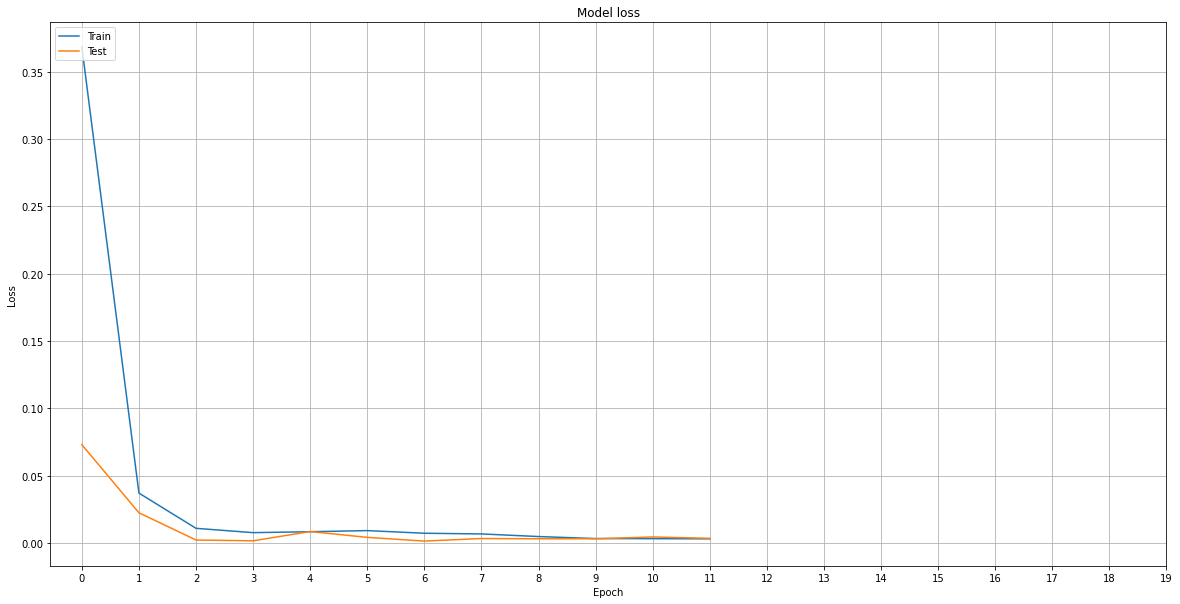

In [21]:
# Plot training & validation loss values
fig, ax = plt.subplots(figsize=(20, 10), sharex=True)
plt.plot(history.history["loss"]) 
plt.plot(history.history["val_loss"])  
plt.title("Model loss")
plt.ylabel("Loss")
plt.xlabel("Epoch")
ax.xaxis.set_major_locator(plt.MaxNLocator(epochs))
plt.xticks(np.arange(20))
plt.legend(["Train", "Test"], loc="upper left")
plt.grid()
plt.show()

In [22]:
from sklearn.metrics import mean_absolute_error
from tensorflow.keras.models import load_model

MAE_list =[]
MAPE_list=[]
MDAPE_list =[]


# Get the predicted values
model = load_model(path)  ### load model with lowest val_loss
y_pred_scaled = model.predict(x_test)

# Unscale the predicted values
y_pred = scaler_pred.inverse_transform(y_pred_scaled)
y_test_unscaled = scaler_pred.inverse_transform(y_test.reshape(-1, 1))

# Mean Absolute Error (MAE)
MAE = mean_absolute_error(y_test_unscaled, y_pred)
print(f'Median Absolute Error (MAE): {np.round(MAE, 2)}')
MAE_list.append(MAE)

# Mean Absolute Percentage Error (MAPE)
MAPE = np.mean((np.abs(np.subtract(y_test_unscaled, y_pred)/ y_test_unscaled))) * 100
print(f'Mean Absolute Percentage Error (MAPE): {np.round(MAPE, 2)} %')
MAPE_list.append(MAPE)

# Median Absolute Percentage Error (MDAPE)
MDAPE = np.median((np.abs(np.subtract(y_test_unscaled, y_pred)/ y_test_unscaled)) ) * 100
print(f'Median Absolute Percentage Error (MDAPE): {np.round(MDAPE, 2)} %')
MDAPE_list.append(MDAPE)

results = list(zip(MAE_list,MAPE_list, MDAPE_list))
results = pd.DataFrame(results,columns =['MAE','MAPE','MDAPE'])

# Add results to dictionary
results_dict['{}_{}dayshift_MAE'.format(ticker, shift)] = MAE_list
results_dict['{}_{}dayshift_MAPE'.format(ticker, shift)] = MAPE_list
results_dict['{}_{}dayshift_MDAPE'.format(ticker, shift)] = MDAPE_list

results

Median Absolute Error (MAE): 0.7
Mean Absolute Percentage Error (MAPE): 15.52 %
Median Absolute Percentage Error (MDAPE): 11.43 %


,MAE,MAPE,MDAPE
0,0.698825,15.515019,11.433386


In [23]:
# The date from which on the date is displayed
display_start_date = pd.Timestamp('today') - timedelta(days=438) #as of 10 April

# Add the date column
data_filtered_sub = data_filtered.copy()
data_filtered_sub['Date'] = df.date

# Add the difference between the valid and predicted prices
train = data_filtered_sub[:train_data_len + 1]
valid = data_filtered_sub[train_data_len:]
valid.insert(1, "Prediction", y_pred.ravel(), True)
valid.insert(1, "Difference", valid["Prediction"] - valid["Close"], True)
valid['Date'] = pd.to_datetime(valid['Date'])
train['Date'] = pd.to_datetime(train['Date'])

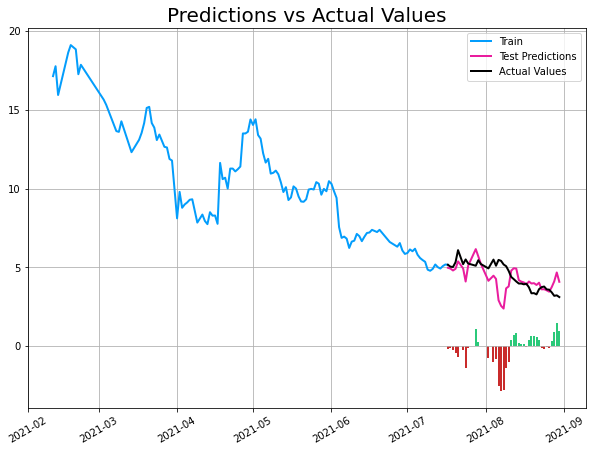

In [24]:
# Zoom in to a closer timeframe
valid = valid[valid['Date'] > display_start_date]
train = train[train['Date'] > display_start_date]

# Visualize the data
fig, ax1 = plt.subplots(figsize=(10, 7), sharex=True)
xt = train['Date']; yt = train[["Close"]]
xv = valid['Date']; yv = valid[["Close", "Prediction"]]
plt.title("Predictions vs Actual Values", fontsize=20)
plt.plot(xt, yt, color="#039dfc", linewidth=2.0)
plt.plot(xv, yv["Prediction"], color="#E91D9E", linewidth=2.0)
plt.plot(xv, yv["Close"], color="black", linewidth=2.0)
plt.legend(["Train", "Test Predictions", "Actual Values"], loc="bottom left")

# # Create the bar plot with the differences
x = valid['Date']
y = valid["Difference"]

# Create custom color range for positive and negative differences
valid.loc[y >= 0, 'diff_color'] = "#2BC97A"
valid.loc[y < 0, 'diff_color'] = "#C92B2B"

plt.bar(x, y, width=0.8, color=valid['diff_color'])
plt.xticks(rotation = 30)

plt.grid()
plt.show()

### 7-Day Shift

In [25]:
## DAILY%CHANGE ##
dep_var = ['Close'] 
other_var = ['day_of_week']
sentiment_vars = [i for i in df.columns if 'comment' in i] +['is_meme']
fin_vars = list(set(df.columns) - set(dep_var+other_var+sentiment_vars+['date'])) # catch all
print('Check that these are all just independent financial vars: '+str(fin_vars))
shift = 7

pred_lag = prep.lag_pred_df(df = df,
                       dep_var = dep_var,
                       other_var = other_var, 
                       fin_vars = fin_vars, 
                       sentiment_vars = sentiment_vars, 
                       shift = shift)

pred_lag = pred_lag.dropna()
pred_lag.head()

Check that these are all just independent financial vars: ['2D%Change', '7Dir', 'Volume', 'Dir', '6Dir', '5D%Change', 'SD', 'SD_log', '3Dir', 'Open', 'High', 'Daily%Change', '6D%Change', '7D%Change', '4Dir', '5Dir', '3D%Change', '4D%Change', 'Low', '2Dir']
Length of dataframe before dropping weekends: 366
Length of dataframe after dropping weekends: 250


,Close,day_of_week,comments_neutral(t-7),comments_positive(t-7),comment_count(t-7),pct_pos_comments(t-7),comments_neutral_rollsum_2D(t-7),comments_neutral_rollmean_2D(t-7),comments_neutral_2D_pctchg(t-7),comments_positive_rollsum_2D(t-7),...,Daily%Change(t-7),6D%Change(t-7),7D%Change(t-7),4Dir(t-7),5Dir(t-7),3D%Change(t-7),4D%Change(t-7),Low(t-7),2Dir(t-7),Close(t-7)
13,24.750000,4,16.0,18.0,34.0,52.941021,24.0,12.0,-80.952381,28.0,...,6.782253,8.835763,14.802636,1.0,1.0,0.047779,0.576373,19.799999,1.0,20.940001
14,25.650000,0,5.0,1.0,6.0,16.666389,7.0,3.5,-44.444444,5.0,...,14.231134,20.808086,24.324326,1.0,1.0,17.485262,14.285713,20.900000,1.0,23.920000
15,27.100000,1,9.0,4.0,13.0,30.768994,14.0,7.0,350.000000,5.0,...,17.600331,35.110469,42.070708,1.0,1.0,43.447212,38.163057,23.780001,1.0,28.129999
16,29.990000,2,7.0,5.0,12.0,41.666319,16.0,8.0,40.000000,9.0,...,-11.713474,18.657423,19.284339,1.0,1.0,18.600757,26.644560,24.400000,1.0,24.834999
17,28.450001,3,3.0,2.0,5.0,39.999200,10.0,5.0,-66.666667,7.0,...,5.053357,28.143415,24.653606,1.0,1.0,9.071907,24.594076,25.000000,0.0,26.090000


In [26]:
# List of considered Features
FEATURES = pred_lag.columns

print('FEATURE LIST')
print([f for f in FEATURES])

# Create the dataset with features and filter the data to the list of FEATURES
data = pred_lag
data_filtered = data[FEATURES]

# We add a prediction column and set dummy values to prepare the data for scaling
data_filtered_ext = data_filtered.copy()
# data_filtered_ext['Prediction'] = data_filtered_ext[dep_var[0]]
#data_filtered_ext.drop(dep_var, axis = 1, inplace = True)

# Print the tail of the dataframe
data_filtered_ext.tail()

FEATURE LIST
['Close', 'day_of_week', 'comments_neutral(t-7)', 'comments_positive(t-7)', 'comment_count(t-7)', 'pct_pos_comments(t-7)', 'comments_neutral_rollsum_2D(t-7)', 'comments_neutral_rollmean_2D(t-7)', 'comments_neutral_2D_pctchg(t-7)', 'comments_positive_rollsum_2D(t-7)', 'comments_positive_rollmean_2D(t-7)', 'comments_positive_2D_pctchg(t-7)', 'comment_count_rollsum_2D(t-7)', 'comment_count_rollmean_2D(t-7)', 'comment_count_2D_pctchg(t-7)', 'pct_pos_comments_rollsum_2D(t-7)', 'pct_pos_comments_rollmean_2D(t-7)', 'pct_pos_comments_2D_pctchg(t-7)', 'comments_neutral_rollsum_3D(t-7)', 'comments_neutral_rollmean_3D(t-7)', 'comments_neutral_3D_pctchg(t-7)', 'comments_positive_rollsum_3D(t-7)', 'comments_positive_rollmean_3D(t-7)', 'comments_positive_3D_pctchg(t-7)', 'comment_count_rollsum_3D(t-7)', 'comment_count_rollmean_3D(t-7)', 'comment_count_3D_pctchg(t-7)', 'pct_pos_comments_rollsum_3D(t-7)', 'pct_pos_comments_rollmean_3D(t-7)', 'pct_pos_comments_3D_pctchg(t-7)', 'comments_ne

,Close,day_of_week,comments_neutral(t-7),comments_positive(t-7),comment_count(t-7),pct_pos_comments(t-7),comments_neutral_rollsum_2D(t-7),comments_neutral_rollmean_2D(t-7),comments_neutral_2D_pctchg(t-7),comments_positive_rollsum_2D(t-7),...,Daily%Change(t-7),6D%Change(t-7),7D%Change(t-7),4Dir(t-7),5Dir(t-7),3D%Change(t-7),4D%Change(t-7),Low(t-7),2Dir(t-7),Close(t-7)
238,3.41,0,6.0,2.0,8.0,24.999688,8.0,4.0,-76.000000,3.0,...,0.298507,-15.365243,-18.048781,0.0,0.0,-15.151519,-14.285719,3.24,0.0,3.36
239,3.19,1,9.0,2.0,11.0,18.181653,15.0,7.5,350.000000,4.0,...,-2.380950,-17.380354,-17.380354,0.0,0.0,-12.064344,-17.171719,3.15,0.0,3.28
240,3.22,2,133.0,29.0,162.0,17.901224,142.0,71.0,2116.666667,31.0,...,10.060973,-7.908168,-9.068013,0.0,0.0,7.761194,-3.217161,3.11,1.0,3.61
241,3.11,3,16.0,5.0,21.0,23.809410,149.0,74.5,77.777778,34.0,...,3.601111,-5.555556,-4.591838,1.0,1.0,11.309528,11.641795,3.60,1.0,3.74
242,3.23,4,8.0,7.0,15.0,46.666356,24.0,12.0,-93.984962,12.0,...,1.069518,1.340481,-4.545456,1.0,1.0,15.243903,12.500003,3.63,1.0,3.78


In [27]:
# Set the sequence length - this is the timeframe used to make a single prediction
sequence_length = 7

# Prediction Index
index_Close = data.columns.get_loc(dep_var[0])

# Split the training data into train and train data sets
# As a first step, we get the number of rows to train the model on 80% of the data 
train_data_len = math.ceil(data_filtered_ext.shape[0] * 0.8)

# Create the training and test data first
train_data = data_filtered.iloc[0:train_data_len] # DATA_FILTERED USED FOR PREDICTION
test_data = data_filtered.iloc[train_data_len - sequence_length:]

# Transform the data by scaling each feature to a range between 0 and 1
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
train_data = scaler.fit_transform(train_data)
test_data = scaler.transform(test_data)

# Convert the data to numpy values
nrows = train_data.shape[0]
train_data = np.array(train_data)
train_data = np.reshape(train_data, (nrows, -1))
print(train_data.shape)

# Convert the data to numpy values
nrows = test_data.shape[0]
test_data = np.array(test_data)
test_data = np.reshape(test_data, (nrows, -1))
print(test_data.shape)

# Creating a separate scaler that works on a single column for scaling predictions
scaler_pred = MinMaxScaler()
df_Close = pd.DataFrame(data_filtered_ext[dep_var[0]][0:train_data_len])
np_Close_scaled = scaler_pred.fit_transform(df_Close)



(163, 100)
(47, 100)


In [28]:
# The RNN needs data with the format of [samples, time steps, features]
# Here, we create N samples, sequence_length time steps per sample, and 6 features
def partition_dataset(sequence_length, data):
    x, y = [], []
    data_len = data.shape[0]
    for i in range(sequence_length, data_len):
        x.append(data[i-sequence_length:i,1:data.shape[1]+1]) #contains sequence_length values 0-sequence_length * columsn
        y.append(data[i, index_Close]) #contains the prediction values for validation,  for single-step prediction
    
    # Convert the x and y to numpy arrays
    x = np.array(x)
    y = np.array(y)
    return x, y

# Generate training data and test data
x_train, y_train = partition_dataset(sequence_length, train_data)
x_test, y_test = partition_dataset(sequence_length, test_data)

# Print the shapes: the result is: (rows, training_sequence, features) (prediction value, )
print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

# Validate that the prediction value and the input match up
# The last close price of the second input sample should equal the first prediction value
print(x_train[1][sequence_length-1][index_Close])
print(y_train[0])

(156, 7, 99) (156,)
(40, 7, 99) (40,)
0.25
0.9227564978992355


In [29]:
# Configure the neural network model
model = Sequential()

# Model with n_neurons = inputshape Timestamps, each with x_train.shape[2] variables
n_neurons = x_train.shape[1] * x_train.shape[2]
print(n_neurons, x_train.shape[1], x_train.shape[2])
model.add(LSTM(n_neurons, return_sequences=True, input_shape=(x_train.shape[1], x_train.shape[2]))) 
model.add(LSTM(n_neurons, return_sequences=False))
model.add(Dense(5))
model.add(Dense(1))

# Compile the model
model.compile(optimizer='adam', loss='mse')

693 7 99


In [30]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
path = '{}_{}_{}shift_Sentiment.h5'.format(ticker, dep_var[0], shift)
# Training the model
epochs = 100
batch_size = 16
early_stop = EarlyStopping(monitor='val_loss', patience=5, verbose=1)
mc = ModelCheckpoint(filepath = path ,monitor='val_loss',save_best_only=True, mode = 'min',verbose=1)
history = model.fit(x_train, y_train, 
                    batch_size=batch_size, 
                    epochs=epochs,
                    validation_data=(x_test, y_test),
                    callbacks = [early_stop,mc]
                   )

Epoch 1/100
10/10 [==============================] - ETA: 0s - loss: 0.4893
Epoch 1: val_loss improved from inf to 0.04857, saving model to WISH_Close_7shift_Sentiment.h5
10/10 [==============================] - 7s 397ms/step - loss: 0.4893 - val_loss: 0.0486
Epoch 2/100
10/10 [==============================] - ETA: 0s - loss: 0.0458
Epoch 2: val_loss improved from 0.04857 to 0.04427, saving model to WISH_Close_7shift_Sentiment.h5
10/10 [==============================] - 3s 298ms/step - loss: 0.0458 - val_loss: 0.0443
Epoch 3/100
10/10 [==============================] - ETA: 0s - loss: 0.0182
Epoch 3: val_loss improved from 0.04427 to 0.00218, saving model to WISH_Close_7shift_Sentiment.h5
10/10 [==============================] - 3s 307ms/step - loss: 0.0182 - val_loss: 0.0022
Epoch 4/100
10/10 [==============================] - ETA: 0s - loss: 0.0122
Epoch 4: val_loss improved from 0.00218 to 0.00166, saving model to WISH_Close_7shift_Sentiment.h5
10/10 [==============================

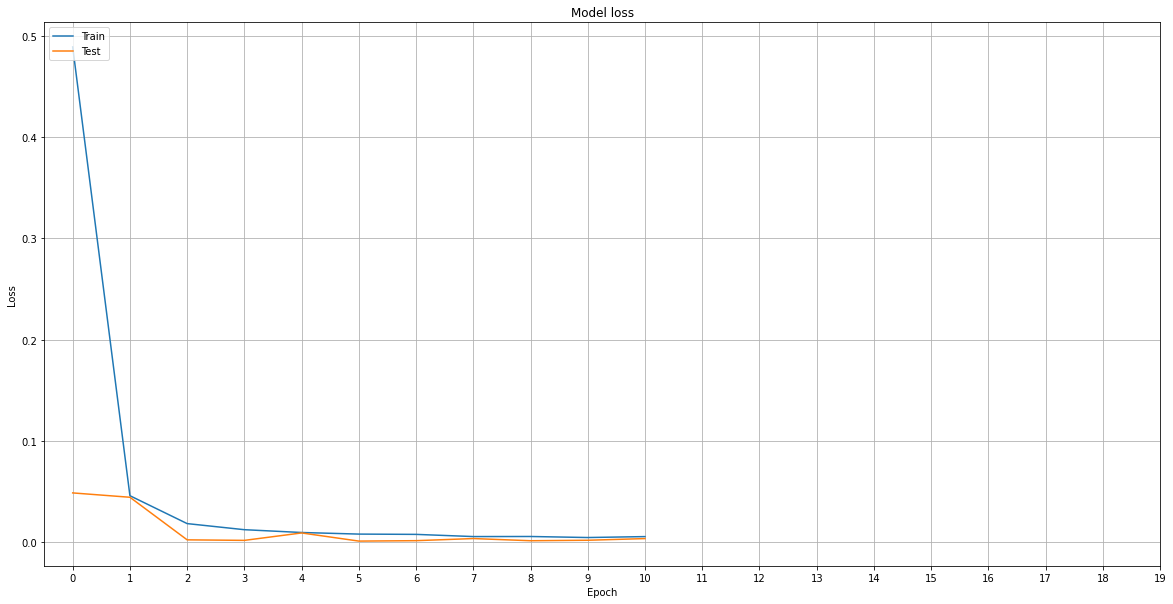

In [31]:
# Plot training & validation loss values
fig, ax = plt.subplots(figsize=(20, 10), sharex=True)
plt.plot(history.history["loss"]) 
plt.plot(history.history["val_loss"])  
plt.title("Model loss")
plt.ylabel("Loss")
plt.xlabel("Epoch")
ax.xaxis.set_major_locator(plt.MaxNLocator(epochs))
plt.xticks(np.arange(20))
plt.legend(["Train", "Test"], loc="upper left")
plt.grid()
plt.show()

In [32]:
from sklearn.metrics import mean_absolute_error
from tensorflow.keras.models import load_model

MAE_list =[]
MAPE_list=[]
MDAPE_list =[]


# Get the predicted values
model = load_model(path)  ### load model with lowest val_loss
y_pred_scaled = model.predict(x_test)

# Unscale the predicted values
y_pred = scaler_pred.inverse_transform(y_pred_scaled)
y_test_unscaled = scaler_pred.inverse_transform(y_test.reshape(-1, 1))

# Mean Absolute Error (MAE)
MAE = mean_absolute_error(y_test_unscaled, y_pred)
print(f'Median Absolute Error (MAE): {np.round(MAE, 2)}')
MAE_list.append(MAE)

# Mean Absolute Percentage Error (MAPE)
MAPE = np.mean((np.abs(np.subtract(y_test_unscaled, y_pred)/ y_test_unscaled))) * 100
print(f'Mean Absolute Percentage Error (MAPE): {np.round(MAPE, 2)} %')
MAPE_list.append(MAPE)

# Median Absolute Percentage Error (MDAPE)
MDAPE = np.median((np.abs(np.subtract(y_test_unscaled, y_pred)/ y_test_unscaled)) ) * 100
print(f'Median Absolute Percentage Error (MDAPE): {np.round(MDAPE, 2)} %')
MDAPE_list.append(MDAPE)

results = list(zip(MAE_list,MAPE_list, MDAPE_list))
results = pd.DataFrame(results,columns =['MAE','MAPE','MDAPE'])

# Add results to dictionary
results_dict['{}_{}dayshift_MAE'.format(ticker, shift)] = MAE_list
results_dict['{}_{}dayshift_MAPE'.format(ticker, shift)] = MAPE_list
results_dict['{}_{}dayshift_MDAPE'.format(ticker, shift)] = MDAPE_list

results

Median Absolute Error (MAE): 0.65
Mean Absolute Percentage Error (MAPE): 14.64 %
Median Absolute Percentage Error (MDAPE): 11.86 %


,MAE,MAPE,MDAPE
0,0.646756,14.637375,11.855586


In [33]:
# The date from which on the date is displayed
display_start_date = pd.Timestamp('today') - timedelta(days=438) #as of 10 April

# Add the date column
data_filtered_sub = data_filtered.copy()
data_filtered_sub['Date'] = df.date

# Add the difference between the valid and predicted prices
train = data_filtered_sub[:train_data_len + 1]
valid = data_filtered_sub[train_data_len:]
valid.insert(1, "Prediction", y_pred.ravel(), True)
valid.insert(1, "Difference", valid["Prediction"] - valid["Close"], True)
valid['Date'] = pd.to_datetime(valid['Date'])
train['Date'] = pd.to_datetime(train['Date'])

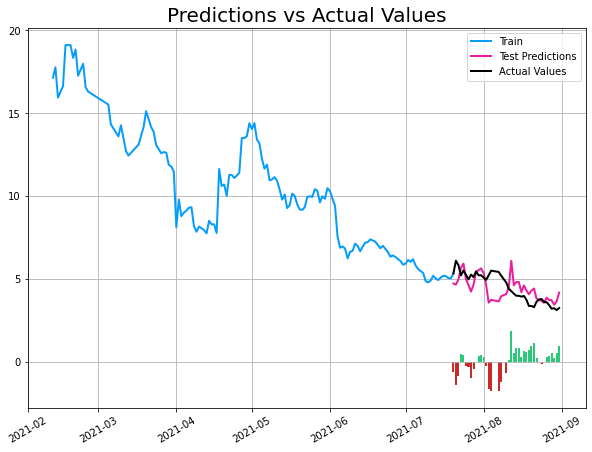

In [34]:
# Zoom in to a closer timeframe
valid = valid[valid['Date'] > display_start_date]
train = train[train['Date'] > display_start_date]

# Visualize the data
fig, ax1 = plt.subplots(figsize=(10, 7), sharex=True)
xt = train['Date']; yt = train[["Close"]]
xv = valid['Date']; yv = valid[["Close", "Prediction"]]
plt.title("Predictions vs Actual Values", fontsize=20)
plt.plot(xt, yt, color="#039dfc", linewidth=2.0)
plt.plot(xv, yv["Prediction"], color="#E91D9E", linewidth=2.0)
plt.plot(xv, yv["Close"], color="black", linewidth=2.0)
plt.legend(["Train", "Test Predictions", "Actual Values"], loc="bottom left")

# # Create the bar plot with the differences
x = valid['Date']
y = valid["Difference"]

# Create custom color range for positive and negative differences
valid.loc[y >= 0, 'diff_color'] = "#2BC97A"
valid.loc[y < 0, 'diff_color'] = "#C92B2B"

plt.bar(x, y, width=0.8, color=valid['diff_color'])
plt.xticks(rotation = 30)

plt.grid()
plt.show()

## LSTM: CLOSE PRICE WITHOUT SENTIMENT

### 1-Day Shift

In [35]:
dep_var = ['Close'] # SET YOUR DEP VAR HERE AND REMOVE IT FROM fin_vars IF NOT YOU WILL GET AN ERROR
other_var = ['day_of_week']
sentiment_vars = [i for i in df.columns if 'comment' in i] +['is_meme']
fin_vars = list(set(df.columns) - set(dep_var+other_var+sentiment_vars+['date'])) # catch all
print('Check that these are all just independent financial vars: '+str(fin_vars))
shift = 1

pred_lag = prep.lag_pred_df(df = df,
                       dep_var = dep_var,
                       other_var = other_var, 
                       fin_vars = fin_vars, 
                       sentiment_vars = sentiment_vars, 
                       shift = shift)

to_drop = [i for i in pred_lag.columns if 'pos' in i] + [i for i in pred_lag.columns if 'neu' in i]
pred_lag = pred_lag.drop(to_drop, axis = 1)

pred_lag = pred_lag.dropna()
pred_lag.head()

Check that these are all just independent financial vars: ['2D%Change', '7Dir', 'Volume', 'Dir', '6Dir', '5D%Change', 'SD', 'SD_log', '3Dir', 'Open', 'High', 'Daily%Change', '6D%Change', '7D%Change', '4Dir', '5Dir', '3D%Change', '4D%Change', 'Low', '2Dir']
Length of dataframe before dropping weekends: 366
Length of dataframe after dropping weekends: 250


,Close,day_of_week,comment_count(t-1),comment_count_rollsum_2D(t-1),comment_count_rollmean_2D(t-1),comment_count_2D_pctchg(t-1),comment_count_rollsum_3D(t-1),comment_count_rollmean_3D(t-1),comment_count_3D_pctchg(t-1),comment_count_rollsum_4D(t-1),...,Daily%Change(t-1),6D%Change(t-1),7D%Change(t-1),4Dir(t-1),5Dir(t-1),3D%Change(t-1),4D%Change(t-1),Low(t-1),2Dir(t-1),Close(t-1)
7,23.920000,2,186.0,190.0,95.0,1330.769231,203.0,67.666667,1228.571429,217.0,...,6.782253,8.835763,14.802636,1.0,1.0,0.047779,0.576373,19.799999,1.0,20.940001
8,28.129999,3,115.0,301.0,150.5,2775.000000,305.0,101.666667,784.615385,318.0,...,14.231134,20.808086,24.324326,1.0,1.0,17.485262,14.285713,20.900000,1.0,23.920000
9,24.834999,4,18.0,133.0,66.5,-90.322581,319.0,106.333333,350.000000,323.0,...,17.600331,35.110469,42.070708,1.0,1.0,43.447212,38.163057,23.780001,1.0,28.129999
10,26.090000,1,6.0,12.0,6.0,-66.666667,30.0,10.000000,-82.352941,64.0,...,-11.713474,18.657423,19.284339,1.0,1.0,18.600757,26.644560,24.400000,1.0,24.834999
11,25.850000,2,13.0,19.0,9.5,116.666667,25.0,8.333333,-27.777778,43.0,...,5.053357,28.143415,24.653606,1.0,1.0,9.071907,24.594076,25.000000,0.0,26.090000


In [36]:
# List of considered Features
FEATURES = pred_lag.columns

print('FEATURE LIST')
print([f for f in FEATURES])

# Create the dataset with features and filter the data to the list of FEATURES
data = pred_lag
data_filtered = data[FEATURES]

# We add a prediction column and set dummy values to prepare the data for scaling
data_filtered_ext = data_filtered.copy()
# data_filtered_ext['Prediction'] = data_filtered_ext[dep_var[0]]
#data_filtered_ext.drop(dep_var, axis = 1, inplace = True)

# Print the tail of the dataframe
data_filtered_ext.tail()


FEATURE LIST
['Close', 'day_of_week', 'comment_count(t-1)', 'comment_count_rollsum_2D(t-1)', 'comment_count_rollmean_2D(t-1)', 'comment_count_2D_pctchg(t-1)', 'comment_count_rollsum_3D(t-1)', 'comment_count_rollmean_3D(t-1)', 'comment_count_3D_pctchg(t-1)', 'comment_count_rollsum_4D(t-1)', 'comment_count_rollmean_4D(t-1)', 'comment_count_4D_pctchg(t-1)', 'comment_count_rollsum_5D(t-1)', 'comment_count_rollmean_5D(t-1)', 'comment_count_5D_pctchg(t-1)', 'comment_count_rollsum_6D(t-1)', 'comment_count_rollmean_6D(t-1)', 'comment_count_6D_pctchg(t-1)', 'comment_count_rollsum_7D(t-1)', 'comment_count_rollmean_7D(t-1)', 'comment_count_7D_pctchg(t-1)', 'is_meme(t-1)', '2D%Change(t-1)', '7Dir(t-1)', 'Volume(t-1)', 'Dir(t-1)', '6Dir(t-1)', '5D%Change(t-1)', 'SD(t-1)', 'SD_log(t-1)', '3Dir(t-1)', 'Open(t-1)', 'High(t-1)', 'Daily%Change(t-1)', '6D%Change(t-1)', '7D%Change(t-1)', '4Dir(t-1)', '5Dir(t-1)', '3D%Change(t-1)', '4D%Change(t-1)', 'Low(t-1)', '2Dir(t-1)', 'Close(t-1)']


,Close,day_of_week,comment_count(t-1),comment_count_rollsum_2D(t-1),comment_count_rollmean_2D(t-1),comment_count_2D_pctchg(t-1),comment_count_rollsum_3D(t-1),comment_count_rollmean_3D(t-1),comment_count_3D_pctchg(t-1),comment_count_rollsum_4D(t-1),...,Daily%Change(t-1),6D%Change(t-1),7D%Change(t-1),4Dir(t-1),5Dir(t-1),3D%Change(t-1),4D%Change(t-1),Low(t-1),2Dir(t-1),Close(t-1)
238,3.41,0,0.0,0.0,0.0,-100.0,15.0,5.000000,-100.0,36.0,...,-0.555555,6.547620,6.865672,0.0,1.0,-4.278077,-0.831024,3.490,0.0,3.58
241,3.11,3,2.0,2.0,1.0,100.0,2.0,0.666667,100.0,2.0,...,0.940438,-13.903743,-10.803321,0.0,0.0,-10.055863,-10.555552,2.970,0.0,3.22
242,3.23,4,5.0,7.0,3.5,100.0,7.0,2.333333,100.0,7.0,...,-3.416153,-17.724870,-16.844923,0.0,0.0,-8.797659,-13.128493,3.055,0.0,3.11
248,3.19,1,4.0,4.0,2.0,100.0,4.0,1.333333,300.0,5.0,...,-6.145252,8.038585,4.347822,1.0,1.0,-5.084748,8.737864,3.330,0.0,3.36
249,3.01,2,5.0,9.0,4.5,100.0,9.0,3.000000,100.0,9.0,...,-5.059519,-1.238389,2.572353,0.0,1.0,-8.333332,-9.887003,3.180,0.0,3.19


In [37]:
# Set the sequence length - this is the timeframe used to make a single prediction
sequence_length = 7

# Prediction Index
index_Close = data.columns.get_loc(dep_var[0])

# Split the training data into train and train data sets
# As a first step, we get the number of rows to train the model on 80% of the data 
train_data_len = math.ceil(data_filtered_ext.shape[0] * 0.8)

# Create the training and test data first
train_data = data_filtered.iloc[0:train_data_len] # DATA_FILTERED USED FOR PREDICTION
test_data = data_filtered.iloc[train_data_len - sequence_length:]

# Transform the data by scaling each feature to a range between 0 and 1
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
train_data = scaler.fit_transform(train_data)
test_data = scaler.transform(test_data)

# Convert the data to numpy values
nrows = train_data.shape[0]
train_data = np.array(train_data)
train_data = np.reshape(train_data, (nrows, -1))
print(train_data.shape)

# Convert the data to numpy values
nrows = test_data.shape[0]
test_data = np.array(test_data)
test_data = np.reshape(test_data, (nrows, -1))
print(test_data.shape)

# Creating a separate scaler that works on a single column for scaling predictions
scaler_pred = MinMaxScaler()
df_Close = pd.DataFrame(data_filtered_ext[dep_var[0]][0:train_data_len])
np_Close_scaled = scaler_pred.fit_transform(df_Close)

(180, 43)
(52, 43)


In [38]:
# The RNN needs data with the format of [samples, time steps, features]
# Here, we create N samples, sequence_length time steps per sample, and 6 features
def partition_dataset(sequence_length, data):
    x, y = [], []
    data_len = data.shape[0]
    for i in range(sequence_length, data_len):
        x.append(data[i-sequence_length:i,1:data.shape[1]+1]) #contains sequence_length values 0-sequence_length * columsn
        y.append(data[i, index_Close]) #contains the prediction values for validation,  for single-step prediction
    
    # Convert the x and y to numpy arrays
    x = np.array(x)
    y = np.array(y)
    return x, y

# Generate training data and test data
x_train, y_train = partition_dataset(sequence_length, train_data)
x_test, y_test = partition_dataset(sequence_length, test_data)

# Print the shapes: the result is: (rows, training_sequence, features) (prediction value, )
print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

# Validate that the prediction value and the input match up
# The last close price of the second input sample should equal the first prediction value
print(x_train[1][sequence_length-1][index_Close])
print(y_train[0])

(173, 7, 42) (173,)
(45, 7, 42) (45,)
0.0
0.7902309410257526


In [39]:
# Configure the neural network model
model = Sequential()

# Model with n_neurons = inputshape Timestamps, each with x_train.shape[2] variables
n_neurons = x_train.shape[1] * x_train.shape[2]
print(n_neurons, x_train.shape[1], x_train.shape[2])
model.add(LSTM(n_neurons, return_sequences=True, input_shape=(x_train.shape[1], x_train.shape[2]))) 
model.add(LSTM(n_neurons, return_sequences=False))
model.add(Dense(5))
model.add(Dense(1))

# Compile the model
model.compile(optimizer='adam', loss='mse')

294 7 42


In [40]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
path = '{}_{}_{}shift_Baseline.h5'.format(ticker, dep_var[0], shift)
# Training the model
epochs = 100
batch_size = 16
early_stop = EarlyStopping(monitor='val_loss', patience=5, verbose=1)
mc = ModelCheckpoint(filepath = path ,monitor='val_loss',save_best_only=True, mode = 'min',verbose=1)
history = model.fit(x_train, y_train, 
                    batch_size=batch_size, 
                    epochs=epochs,
                    validation_data=(x_test, y_test),
                    callbacks = [early_stop,mc]
                   )

Epoch 1/100
11/11 [==============================] - ETA: 0s - loss: 0.0693
Epoch 1: val_loss improved from inf to 0.01278, saving model to WISH_Close_1shift_Baseline.h5
11/11 [==============================] - 5s 160ms/step - loss: 0.0693 - val_loss: 0.0128
Epoch 2/100
11/11 [==============================] - ETA: 0s - loss: 0.0095
Epoch 2: val_loss improved from 0.01278 to 0.00365, saving model to WISH_Close_1shift_Baseline.h5
11/11 [==============================] - 1s 72ms/step - loss: 0.0095 - val_loss: 0.0037
Epoch 3/100
10/11 [==========================>...] - ETA: 0s - loss: 0.0047
Epoch 3: val_loss improved from 0.00365 to 0.00276, saving model to WISH_Close_1shift_Baseline.h5
11/11 [==============================] - 1s 70ms/step - loss: 0.0046 - val_loss: 0.0028
Epoch 4/100
11/11 [==============================] - ETA: 0s - loss: 0.0032
Epoch 4: val_loss improved from 0.00276 to 0.00197, saving model to WISH_Close_1shift_Baseline.h5
11/11 [==============================] - 1s

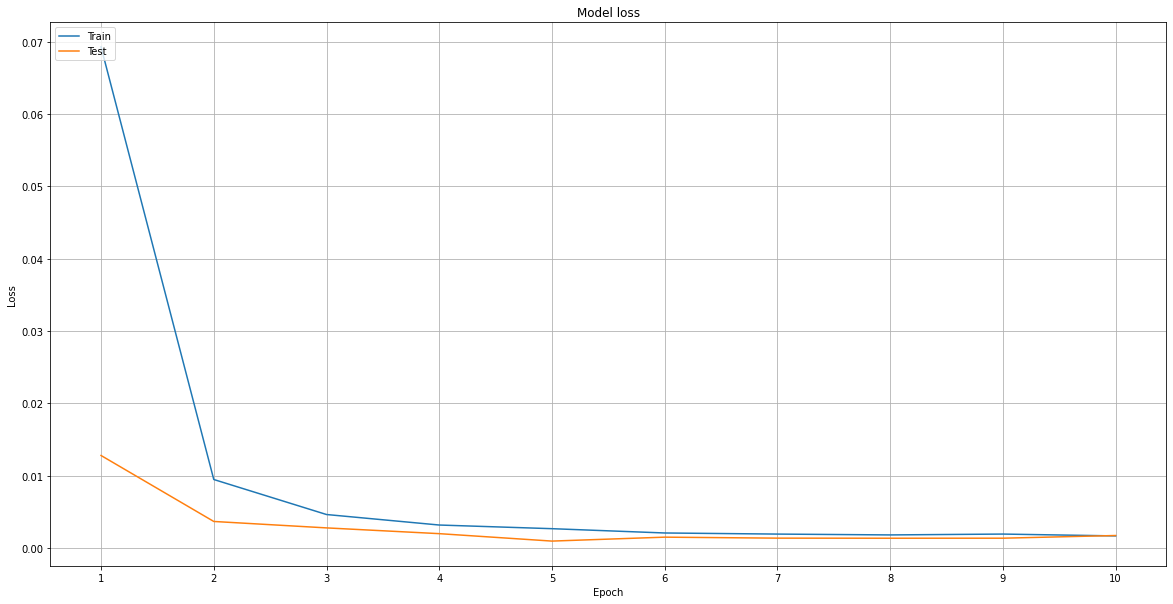

In [41]:
# Plot training & validation loss values
fig, ax = plt.subplots(figsize=(20, 10), sharex=True)
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])  
plt.title("Model loss")
plt.ylabel("Loss")
plt.xlabel("Epoch")
ax.xaxis.set_major_locator(plt.MaxNLocator(epochs))
plt.xticks(np.arange(10), np.arange(1, 11))
plt.legend(["Train", "Test"], loc="upper left")
plt.grid()
plt.show()

In [42]:
MAE_list =[]
MAPE_list=[]
MDAPE_list =[]


# Get the predicted values
model = load_model(path)  ### load model with lowest val_loss
y_pred_scaled = model.predict(x_test)

# Unscale the predicted values
y_pred = scaler_pred.inverse_transform(y_pred_scaled)
y_test_unscaled = scaler_pred.inverse_transform(y_test.reshape(-1, 1))

# Mean Absolute Error (MAE)
MAE = mean_absolute_error(y_test_unscaled, y_pred)
print(f'Median Absolute Error (MAE): {np.round(MAE, 2)}')
MAE_list.append(MAE)

# Mean Absolute Percentage Error (MAPE)
MAPE = np.mean((np.abs(np.subtract(y_test_unscaled, y_pred)/ y_test_unscaled))) * 100
print(f'Mean Absolute Percentage Error (MAPE): {np.round(MAPE, 2)} %')
MAPE_list.append(MAPE)

# Median Absolute Percentage Error (MDAPE)
MDAPE = np.median((np.abs(np.subtract(y_test_unscaled, y_pred)/ y_test_unscaled)) ) * 100
print(f'Median Absolute Percentage Error (MDAPE): {np.round(MDAPE, 2)} %')
MDAPE_list.append(MDAPE)

results = list(zip(MAE_list,MAPE_list, MDAPE_list))
results = pd.DataFrame(results,columns =['MAE','MAPE','MDAPE'])

# Add results to dictionary
results_dict['{}_{}dayshift_MAE_baseline'.format(ticker, shift)] = MAE_list
results_dict['{}_{}dayshift_MAPE_baseline'.format(ticker, shift)] = MAPE_list
results_dict['{}_{}dayshift_MDAPE_baseline'.format(ticker, shift)] = MDAPE_list


results

Median Absolute Error (MAE): 0.67
Mean Absolute Percentage Error (MAPE): 14.8 %
Median Absolute Percentage Error (MDAPE): 14.33 %


,MAE,MAPE,MDAPE
0,0.66907,14.802798,14.332253


In [43]:
# The date from which on the date is displayed
display_start_date = pd.Timestamp('today') - timedelta(days=438) #as of 10 April

# Add the date column
data_filtered_sub = data_filtered.copy()
data_filtered_sub['Date'] = df.date

# Add the difference between the valid and predicted prices
train = data_filtered_sub[:train_data_len + 1]
valid = data_filtered_sub[train_data_len:]
valid.insert(1, "Prediction", y_pred.ravel(), True)
valid.insert(1, "Difference", valid["Prediction"] - valid[dep_var[0]], True)

valid['Date'] = pd.to_datetime(valid['Date'])
train['Date'] = pd.to_datetime(train['Date'])

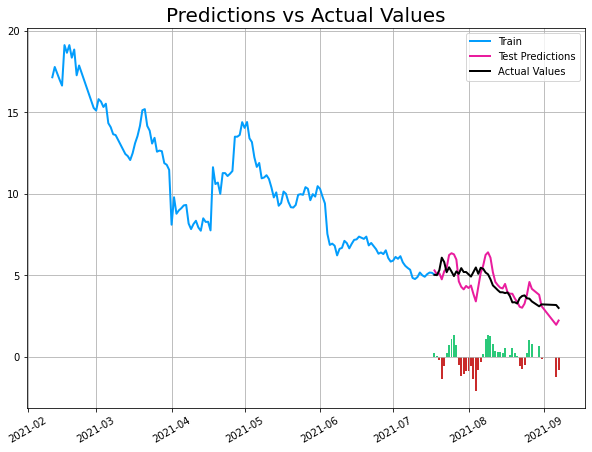

In [44]:
# Zoom in to a closer timeframe
valid = valid[valid['Date'] > display_start_date]
train = train[train['Date'] > display_start_date]

# Visualize the data
fig, ax1 = plt.subplots(figsize=(10, 7), sharex=True)
xt = train['Date']; yt = train[["Close"]]
xv = valid['Date']; yv = valid[["Close", "Prediction"]]
plt.title("Predictions vs Actual Values", fontsize=20)
plt.plot(xt, yt, color="#039dfc", linewidth=2.0)
plt.plot(xv, yv["Prediction"], color="#E91D9E", linewidth=2.0)
plt.plot(xv, yv["Close"], color="black", linewidth=2.0)
plt.legend(["Train", "Test Predictions", "Actual Values"], loc="bottom left")

# # Create the bar plot with the differences
x = valid['Date']
y = valid["Difference"]

# Create custom color range for positive and negative differences
valid.loc[y >= 0, 'diff_color'] = "#2BC97A"
valid.loc[y < 0, 'diff_color'] = "#C92B2B"

plt.bar(x, y, width=0.8, color=valid['diff_color'])
plt.xticks(rotation = 30)

plt.grid()
plt.show()

### 4-Day Shift

In [45]:
dep_var = ['Close'] # SET YOUR DEP VAR HERE AND REMOVE IT FROM fin_vars IF NOT YOU WILL GET AN ERROR
other_var = ['day_of_week']
sentiment_vars = [i for i in df.columns if 'comment' in i] +['is_meme']
fin_vars = list(set(df.columns) - set(dep_var+other_var+sentiment_vars+['date'])) # catch all
print('Check that these are all just independent financial vars: '+str(fin_vars))
shift = 4

pred_lag = prep.lag_pred_df(df = df,
                       dep_var = dep_var,
                       other_var = other_var, 
                       fin_vars = fin_vars, 
                       sentiment_vars = sentiment_vars, 
                       shift = shift)

to_drop = [i for i in pred_lag.columns if 'pos' in i] + [i for i in pred_lag.columns if 'neu' in i]
pred_lag = pred_lag.drop(to_drop, axis = 1)

pred_lag = pred_lag.dropna()
pred_lag.head()

Check that these are all just independent financial vars: ['2D%Change', '7Dir', 'Volume', 'Dir', '6Dir', '5D%Change', 'SD', 'SD_log', '3Dir', 'Open', 'High', 'Daily%Change', '6D%Change', '7D%Change', '4Dir', '5Dir', '3D%Change', '4D%Change', 'Low', '2Dir']
Length of dataframe before dropping weekends: 366
Length of dataframe after dropping weekends: 250


,Close,day_of_week,comment_count(t-4),comment_count_rollsum_2D(t-4),comment_count_rollmean_2D(t-4),comment_count_2D_pctchg(t-4),comment_count_rollsum_3D(t-4),comment_count_rollmean_3D(t-4),comment_count_3D_pctchg(t-4),comment_count_rollsum_4D(t-4),...,Daily%Change(t-4),6D%Change(t-4),7D%Change(t-4),4Dir(t-4),5Dir(t-4),3D%Change(t-4),4D%Change(t-4),Low(t-4),2Dir(t-4),Close(t-4)
10,26.09,1,34.0,52.0,26.0,-70.434783,167.0,55.666667,-81.720430,353.0,...,6.782253,8.835763,14.802636,1.0,1.0,0.047779,0.576373,19.799999,1.0,20.940001
11,25.85,2,18.0,52.0,26.0,0.000000,70.0,23.333333,-84.347826,185.0,...,14.231134,20.808086,24.324326,1.0,1.0,17.485262,14.285713,20.900000,1.0,23.920000
12,24.84,3,6.0,24.0,12.0,-82.352941,58.0,19.333333,-66.666667,76.0,...,17.600331,35.110469,42.070708,1.0,1.0,43.447212,38.163057,23.780001,1.0,28.129999
13,24.75,4,6.0,12.0,6.0,-66.666667,30.0,10.000000,-82.352941,64.0,...,-11.713474,18.657423,19.284339,1.0,1.0,18.600757,26.644560,24.400000,1.0,24.834999
14,25.65,0,5.0,17.0,8.5,-61.538462,30.0,10.000000,-16.666667,36.0,...,5.053357,28.143415,24.653606,1.0,1.0,9.071907,24.594076,25.000000,0.0,26.090000


In [46]:
# List of considered Features
FEATURES = pred_lag.columns

print('FEATURE LIST')
print([f for f in FEATURES])

# Create the dataset with features and filter the data to the list of FEATURES
data = pred_lag
data_filtered = data[FEATURES]

# We add a prediction column and set dummy values to prepare the data for scaling
data_filtered_ext = data_filtered.copy()
# data_filtered_ext['Prediction'] = data_filtered_ext[dep_var[0]]
#data_filtered_ext.drop(dep_var, axis = 1, inplace = True)

# Print the tail of the dataframe
data_filtered_ext.tail()

FEATURE LIST
['Close', 'day_of_week', 'comment_count(t-4)', 'comment_count_rollsum_2D(t-4)', 'comment_count_rollmean_2D(t-4)', 'comment_count_2D_pctchg(t-4)', 'comment_count_rollsum_3D(t-4)', 'comment_count_rollmean_3D(t-4)', 'comment_count_3D_pctchg(t-4)', 'comment_count_rollsum_4D(t-4)', 'comment_count_rollmean_4D(t-4)', 'comment_count_4D_pctchg(t-4)', 'comment_count_rollsum_5D(t-4)', 'comment_count_rollmean_5D(t-4)', 'comment_count_5D_pctchg(t-4)', 'comment_count_rollsum_6D(t-4)', 'comment_count_rollmean_6D(t-4)', 'comment_count_6D_pctchg(t-4)', 'comment_count_rollsum_7D(t-4)', 'comment_count_rollmean_7D(t-4)', 'comment_count_7D_pctchg(t-4)', 'is_meme(t-4)', '2D%Change(t-4)', '7Dir(t-4)', 'Volume(t-4)', 'Dir(t-4)', '6Dir(t-4)', '5D%Change(t-4)', 'SD(t-4)', 'SD_log(t-4)', '3Dir(t-4)', 'Open(t-4)', 'High(t-4)', 'Daily%Change(t-4)', '6D%Change(t-4)', '7D%Change(t-4)', '4Dir(t-4)', '5Dir(t-4)', '3D%Change(t-4)', '4D%Change(t-4)', 'Low(t-4)', '2Dir(t-4)', 'Close(t-4)']


,Close,day_of_week,comment_count(t-4),comment_count_rollsum_2D(t-4),comment_count_rollmean_2D(t-4),comment_count_2D_pctchg(t-4),comment_count_rollsum_3D(t-4),comment_count_rollmean_3D(t-4),comment_count_3D_pctchg(t-4),comment_count_rollsum_4D(t-4),...,Daily%Change(t-4),6D%Change(t-4),7D%Change(t-4),4Dir(t-4),5Dir(t-4),3D%Change(t-4),4D%Change(t-4),Low(t-4),2Dir(t-4),Close(t-4)
240,3.22,2,0.0,15.0,7.5,-100.0,36.0,12.000000,-100.0,198.0,...,-4.761907,7.462687,-3.485258,1.0,1.0,-0.277008,9.756096,3.60,0.0,3.60
241,3.11,3,0.0,0.0,0.0,-100.0,15.0,5.000000,-100.0,36.0,...,-0.555555,6.547620,6.865672,0.0,1.0,-4.278077,-0.831024,3.49,0.0,3.58
243,3.09,0,5.0,7.0,3.5,100.0,7.0,2.333333,100.0,7.0,...,-6.451614,-11.634345,-2.743900,0.0,0.0,-11.388885,-15.608463,3.19,0.0,3.19
247,3.36,0,2.0,2.0,1.0,100.0,2.0,0.666667,100.0,2.0,...,-4.334369,-13.687151,-14.166667,0.0,0.0,-4.037271,-3.134801,3.06,0.0,3.09
248,3.19,1,1.0,3.0,1.5,100.0,3.0,1.000000,100.0,3.0,...,14.563109,3.812313,-1.117317,1.0,1.0,13.826369,9.937886,3.14,1.0,3.54


In [47]:
# Set the sequence length - this is the timeframe used to make a single prediction
sequence_length = 7

# Prediction Index
index_Close = data.columns.get_loc(dep_var[0])

# Split the training data into train and train data sets
# As a first step, we get the number of rows to train the model on 80% of the data 
train_data_len = math.ceil(data_filtered_ext.shape[0] * 0.8)

# Create the training and test data first
train_data = data_filtered.iloc[0:train_data_len] # DATA_FILTERED USED FOR PREDICTION
test_data = data_filtered.iloc[train_data_len - sequence_length:]

# Transform the data by scaling each feature to a range between 0 and 1
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
train_data = scaler.fit_transform(train_data)
test_data = scaler.transform(test_data)

# Convert the data to numpy values
nrows = train_data.shape[0]
train_data = np.array(train_data)
train_data = np.reshape(train_data, (nrows, -1))
print(train_data.shape)

# Convert the data to numpy values
nrows = test_data.shape[0]
test_data = np.array(test_data)
test_data = np.reshape(test_data, (nrows, -1))
print(test_data.shape)

# Creating a separate scaler that works on a single column for scaling predictions
scaler_pred = MinMaxScaler()
df_Close = pd.DataFrame(data_filtered_ext[dep_var[0]][0:train_data_len])
np_Close_scaled = scaler_pred.fit_transform(df_Close)

(178, 43)
(51, 43)


In [48]:
# The RNN needs data with the format of [samples, time steps, features]
# Here, we create N samples, sequence_length time steps per sample, and 6 features
def partition_dataset(sequence_length, data):
    x, y = [], []
    data_len = data.shape[0]
    for i in range(sequence_length, data_len):
        x.append(data[i-sequence_length:i,1:data.shape[1]+1]) #contains sequence_length values 0-sequence_length * columsn
        y.append(data[i, index_Close]) #contains the prediction values for validation,  for single-step prediction
    
    # Convert the x and y to numpy arrays
    x = np.array(x)
    y = np.array(y)
    return x, y

# Generate training data and test data
x_train, y_train = partition_dataset(sequence_length, train_data)
x_test, y_test = partition_dataset(sequence_length, test_data)

# Print the shapes: the result is: (rows, training_sequence, features) (prediction value, )
print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

# Validate that the prediction value and the input match up
# The last close price of the second input sample should equal the first prediction value
print(x_train[1][sequence_length-1][index_Close])
print(y_train[0])

(171, 7, 42) (171,)
(44, 7, 42) (44,)
0.75
0.896251429856957


In [49]:
# Configure the neural network model
model = Sequential()

# Model with n_neurons = inputshape Timestamps, each with x_train.shape[2] variables
n_neurons = x_train.shape[1] * x_train.shape[2]
print(n_neurons, x_train.shape[1], x_train.shape[2])
model.add(LSTM(n_neurons, return_sequences=True, input_shape=(x_train.shape[1], x_train.shape[2]))) 
model.add(LSTM(n_neurons, return_sequences=False))
model.add(Dense(5))
model.add(Dense(1))

# Compile the model
model.compile(optimizer='adam', loss='mse')

294 7 42


In [50]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
path = '{}_{}_{}shift_Baseline.h5'.format(ticker, dep_var[0], shift)
# Training the model
epochs = 100
batch_size = 16
early_stop = EarlyStopping(monitor='val_loss', patience=5, verbose=1)
mc = ModelCheckpoint(filepath = path ,monitor='val_loss',save_best_only=True, mode = 'min',verbose=1)
history = model.fit(x_train, y_train, 
                    batch_size=batch_size, 
                    epochs=epochs,
                    validation_data=(x_test, y_test),
                    callbacks = [early_stop,mc]
                   )

Epoch 1/100
10/11 [==========================>...] - ETA: 0s - loss: 0.0885
Epoch 1: val_loss improved from inf to 0.04770, saving model to WISH_Close_4shift_Baseline.h5
11/11 [==============================] - 5s 156ms/step - loss: 0.0836 - val_loss: 0.0477
Epoch 2/100
10/11 [==========================>...] - ETA: 0s - loss: 0.0169
Epoch 2: val_loss improved from 0.04770 to 0.00636, saving model to WISH_Close_4shift_Baseline.h5
11/11 [==============================] - 1s 71ms/step - loss: 0.0164 - val_loss: 0.0064
Epoch 3/100
10/11 [==========================>...] - ETA: 0s - loss: 0.0092
Epoch 3: val_loss improved from 0.00636 to 0.00294, saving model to WISH_Close_4shift_Baseline.h5
11/11 [==============================] - 1s 69ms/step - loss: 0.0091 - val_loss: 0.0029
Epoch 4/100
11/11 [==============================] - ETA: 0s - loss: 0.0078
Epoch 4: val_loss improved from 0.00294 to 0.00136, saving model to WISH_Close_4shift_Baseline.h5
11/11 [==============================] - 1s

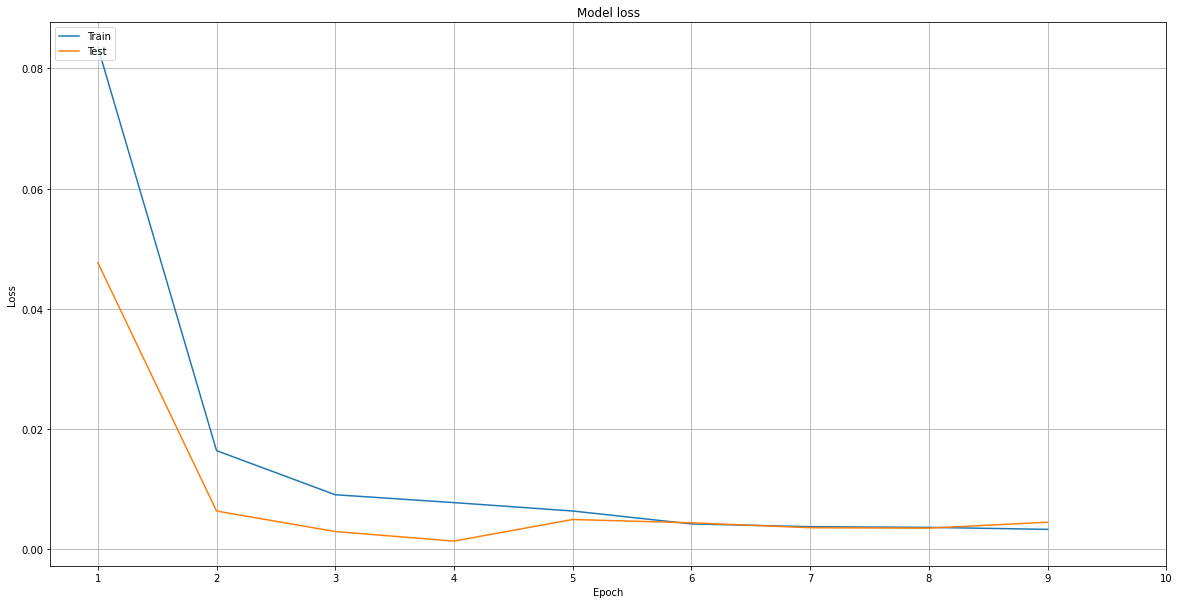

In [51]:
# Plot training & validation loss values
fig, ax = plt.subplots(figsize=(20, 10), sharex=True)
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])  
plt.title("Model loss")
plt.ylabel("Loss")
plt.xlabel("Epoch")
ax.xaxis.set_major_locator(plt.MaxNLocator(epochs))
plt.xticks(np.arange(10), np.arange(1, 11))
plt.legend(["Train", "Test"], loc="upper left")
plt.grid()
plt.show()

In [52]:
MAE_list =[]
MAPE_list=[]
MDAPE_list =[]


# Get the predicted values
model = load_model(path)  ### load model with lowest val_loss
y_pred_scaled = model.predict(x_test)

# Unscale the predicted values
y_pred = scaler_pred.inverse_transform(y_pred_scaled)
y_test_unscaled = scaler_pred.inverse_transform(y_test.reshape(-1, 1))

# Mean Absolute Error (MAE)
MAE = mean_absolute_error(y_test_unscaled, y_pred)
print(f'Median Absolute Error (MAE): {np.round(MAE, 2)}')
MAE_list.append(MAE)

# Mean Absolute Percentage Error (MAPE)
MAPE = np.mean((np.abs(np.subtract(y_test_unscaled, y_pred)/ y_test_unscaled))) * 100
print(f'Mean Absolute Percentage Error (MAPE): {np.round(MAPE, 2)} %')
MAPE_list.append(MAPE)

# Median Absolute Percentage Error (MDAPE)
MDAPE = np.median((np.abs(np.subtract(y_test_unscaled, y_pred)/ y_test_unscaled)) ) * 100
print(f'Median Absolute Percentage Error (MDAPE): {np.round(MDAPE, 2)} %')
MDAPE_list.append(MDAPE)

results = list(zip(MAE_list,MAPE_list, MDAPE_list))
results = pd.DataFrame(results,columns =['MAE','MAPE','MDAPE'])

# Add results to dictionary
results_dict['{}_{}dayshift_MAE_baseline'.format(ticker, shift)] = MAE_list
results_dict['{}_{}dayshift_MAPE_baseline'.format(ticker, shift)] = MAPE_list
results_dict['{}_{}dayshift_MDAPE_baseline'.format(ticker, shift)] = MDAPE_list


results

Median Absolute Error (MAE): 0.8
Mean Absolute Percentage Error (MAPE): 17.95 %
Median Absolute Percentage Error (MDAPE): 17.84 %


,MAE,MAPE,MDAPE
0,0.796168,17.95473,17.839609


In [53]:
# The date from which on the date is displayed
display_start_date = pd.Timestamp('today') - timedelta(days=438) #as of 10 April

# Add the date column
data_filtered_sub = data_filtered.copy()
data_filtered_sub['Date'] = df.date

# Add the difference between the valid and predicted prices
train = data_filtered_sub[:train_data_len + 1]
valid = data_filtered_sub[train_data_len:]
valid.insert(1, "Prediction", y_pred.ravel(), True)
valid.insert(1, "Difference", valid["Prediction"] - valid[dep_var[0]], True)

valid['Date'] = pd.to_datetime(valid['Date'])
train['Date'] = pd.to_datetime(train['Date'])

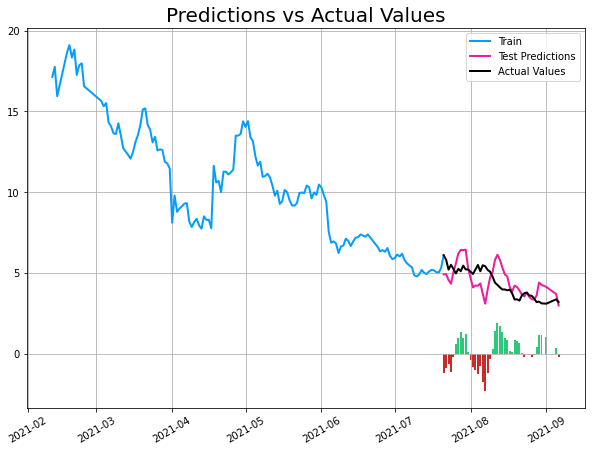

In [54]:
# Zoom in to a closer timeframe
valid = valid[valid['Date'] > display_start_date]
train = train[train['Date'] > display_start_date]

# Visualize the data
fig, ax1 = plt.subplots(figsize=(10, 7), sharex=True)
xt = train['Date']; yt = train[["Close"]]
xv = valid['Date']; yv = valid[["Close", "Prediction"]]
plt.title("Predictions vs Actual Values", fontsize=20)
plt.plot(xt, yt, color="#039dfc", linewidth=2.0)
plt.plot(xv, yv["Prediction"], color="#E91D9E", linewidth=2.0)
plt.plot(xv, yv["Close"], color="black", linewidth=2.0)
plt.legend(["Train", "Test Predictions", "Actual Values"], loc="bottom left")

# # Create the bar plot with the differences
x = valid['Date']
y = valid["Difference"]

# Create custom color range for positive and negative differences
valid.loc[y >= 0, 'diff_color'] = "#2BC97A"
valid.loc[y < 0, 'diff_color'] = "#C92B2B"

plt.bar(x, y, width=0.8, color=valid['diff_color'])
plt.xticks(rotation = 30)

plt.grid()
plt.show()

### 7-Day Shift

In [55]:
bdep_var = ['Close'] # SET YOUR DEP VAR HERE AND REMOVE IT FROM fin_vars IF NOT YOU WILL GET AN ERROR
other_var = ['day_of_week']
sentiment_vars = [i for i in df.columns if 'comment' in i] +['is_meme']
fin_vars = list(set(df.columns) - set(dep_var+other_var+sentiment_vars+['date'])) # catch all
print('Check that these are all just independent financial vars: '+str(fin_vars))
shift = 7

pred_lag = prep.lag_pred_df(df = df,
                       dep_var = dep_var,
                       other_var = other_var, 
                       fin_vars = fin_vars, 
                       sentiment_vars = sentiment_vars, 
                       shift = shift)

to_drop = [i for i in pred_lag.columns if 'pos' in i] + [i for i in pred_lag.columns if 'neu' in i]
pred_lag = pred_lag.drop(to_drop, axis = 1)

pred_lag = pred_lag.dropna()
pred_lag.head()

Check that these are all just independent financial vars: ['2D%Change', '7Dir', 'Volume', 'Dir', '6Dir', '5D%Change', 'SD', 'SD_log', '3Dir', 'Open', 'High', 'Daily%Change', '6D%Change', '7D%Change', '4Dir', '5Dir', '3D%Change', '4D%Change', 'Low', '2Dir']
Length of dataframe before dropping weekends: 366
Length of dataframe after dropping weekends: 250


,Close,day_of_week,comment_count(t-7),comment_count_rollsum_2D(t-7),comment_count_rollmean_2D(t-7),comment_count_2D_pctchg(t-7),comment_count_rollsum_3D(t-7),comment_count_rollmean_3D(t-7),comment_count_3D_pctchg(t-7),comment_count_rollsum_4D(t-7),...,Daily%Change(t-7),6D%Change(t-7),7D%Change(t-7),4Dir(t-7),5Dir(t-7),3D%Change(t-7),4D%Change(t-7),Low(t-7),2Dir(t-7),Close(t-7)
13,24.750000,4,34.0,52.0,26.0,-70.434783,167.0,55.666667,-81.720430,353.0,...,6.782253,8.835763,14.802636,1.0,1.0,0.047779,0.576373,19.799999,1.0,20.940001
14,25.650000,0,6.0,12.0,6.0,-66.666667,30.0,10.000000,-82.352941,64.0,...,14.231134,20.808086,24.324326,1.0,1.0,17.485262,14.285713,20.900000,1.0,23.920000
15,27.100000,1,13.0,19.0,9.5,116.666667,25.0,8.333333,-27.777778,43.0,...,17.600331,35.110469,42.070708,1.0,1.0,43.447212,38.163057,23.780001,1.0,28.129999
16,29.990000,2,12.0,25.0,12.5,100.000000,31.0,10.333333,100.000000,37.0,...,-11.713474,18.657423,19.284339,1.0,1.0,18.600757,26.644560,24.400000,1.0,24.834999
17,28.450001,3,5.0,17.0,8.5,-61.538462,30.0,10.000000,-16.666667,36.0,...,5.053357,28.143415,24.653606,1.0,1.0,9.071907,24.594076,25.000000,0.0,26.090000


In [56]:
# List of considered Features
FEATURES = pred_lag.columns

print('FEATURE LIST')
print([f for f in FEATURES])

# Create the dataset with features and filter the data to the list of FEATURES
data = pred_lag
data_filtered = data[FEATURES]

# We add a prediction column and set dummy values to prepare the data for scaling
data_filtered_ext = data_filtered.copy()
# data_filtered_ext['Prediction'] = data_filtered_ext[dep_var[0]]
#data_filtered_ext.drop(dep_var, axis = 1, inplace = True)

# Print the tail of the dataframe
data_filtered_ext.tail()

FEATURE LIST
['Close', 'day_of_week', 'comment_count(t-7)', 'comment_count_rollsum_2D(t-7)', 'comment_count_rollmean_2D(t-7)', 'comment_count_2D_pctchg(t-7)', 'comment_count_rollsum_3D(t-7)', 'comment_count_rollmean_3D(t-7)', 'comment_count_3D_pctchg(t-7)', 'comment_count_rollsum_4D(t-7)', 'comment_count_rollmean_4D(t-7)', 'comment_count_4D_pctchg(t-7)', 'comment_count_rollsum_5D(t-7)', 'comment_count_rollmean_5D(t-7)', 'comment_count_5D_pctchg(t-7)', 'comment_count_rollsum_6D(t-7)', 'comment_count_rollmean_6D(t-7)', 'comment_count_6D_pctchg(t-7)', 'comment_count_rollsum_7D(t-7)', 'comment_count_rollmean_7D(t-7)', 'comment_count_7D_pctchg(t-7)', 'is_meme(t-7)', '2D%Change(t-7)', '7Dir(t-7)', 'Volume(t-7)', 'Dir(t-7)', '6Dir(t-7)', '5D%Change(t-7)', 'SD(t-7)', 'SD_log(t-7)', '3Dir(t-7)', 'Open(t-7)', 'High(t-7)', 'Daily%Change(t-7)', '6D%Change(t-7)', '7D%Change(t-7)', '4Dir(t-7)', '5Dir(t-7)', '3D%Change(t-7)', '4D%Change(t-7)', 'Low(t-7)', '2Dir(t-7)', 'Close(t-7)']


,Close,day_of_week,comment_count(t-7),comment_count_rollsum_2D(t-7),comment_count_rollmean_2D(t-7),comment_count_2D_pctchg(t-7),comment_count_rollsum_3D(t-7),comment_count_rollmean_3D(t-7),comment_count_3D_pctchg(t-7),comment_count_rollsum_4D(t-7),...,Daily%Change(t-7),6D%Change(t-7),7D%Change(t-7),4Dir(t-7),5Dir(t-7),3D%Change(t-7),4D%Change(t-7),Low(t-7),2Dir(t-7),Close(t-7)
240,3.22,2,162.0,173.0,86.5,1925.000000,181.0,60.333333,5300.000000,184.0,...,10.060973,-7.908168,-9.068013,0.0,0.0,7.761194,-3.217161,3.11,1.0,3.61
241,3.11,3,21.0,183.0,91.5,90.909091,194.0,64.666667,162.500000,202.0,...,3.601111,-5.555556,-4.591838,1.0,1.0,11.309528,11.641795,3.60,1.0,3.74
242,3.23,4,15.0,36.0,18.0,-90.740741,198.0,66.000000,36.363636,209.0,...,1.069518,1.340481,-4.545456,1.0,1.0,15.243903,12.500003,3.63,1.0,3.78
245,3.48,2,2.0,2.0,1.0,100.000000,2.0,0.666667,100.000000,2.0,...,-4.748599,3.963418,1.488101,0.0,0.0,-9.788357,-8.823527,3.33,0.0,3.41
246,3.58,3,5.0,7.0,3.5,100.000000,7.0,2.333333,100.000000,7.0,...,-6.451614,-11.634345,-2.743900,0.0,0.0,-11.388885,-15.608463,3.19,0.0,3.19


In [57]:
# Set the sequence length - this is the timeframe used to make a single prediction
sequence_length = 7

# Prediction Index
index_Close = data.columns.get_loc(dep_var[0])

# Split the training data into train and train data sets
# As a first step, we get the number of rows to train the model on 80% of the data 
train_data_len = math.ceil(data_filtered_ext.shape[0] * 0.8)

# Create the training and test data first
train_data = data_filtered.iloc[0:train_data_len] # DATA_FILTERED USED FOR PREDICTION
test_data = data_filtered.iloc[train_data_len - sequence_length:]

# Transform the data by scaling each feature to a range between 0 and 1
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
train_data = scaler.fit_transform(train_data)
test_data = scaler.transform(test_data)

# Convert the data to numpy values
nrows = train_data.shape[0]
train_data = np.array(train_data)
train_data = np.reshape(train_data, (nrows, -1))
print(train_data.shape)

# Convert the data to numpy values
nrows = test_data.shape[0]
test_data = np.array(test_data)
test_data = np.reshape(test_data, (nrows, -1))
print(test_data.shape)

# Creating a separate scaler that works on a single column for scaling predictions
scaler_pred = MinMaxScaler()
df_Close = pd.DataFrame(data_filtered_ext[dep_var[0]][0:train_data_len])
np_Close_scaled = scaler_pred.fit_transform(df_Close)


(179, 43)
(51, 43)


In [58]:
# The RNN needs data with the format of [samples, time steps, features]
# Here, we create N samples, sequence_length time steps per sample, and 6 features
def partition_dataset(sequence_length, data):
    x, y = [], []
    data_len = data.shape[0]
    for i in range(sequence_length, data_len):
        x.append(data[i-sequence_length:i,1:data.shape[1]+1]) #contains sequence_length values 0-sequence_length * columsn
        y.append(data[i, index_Close]) #contains the prediction values for validation,  for single-step prediction
    
    # Convert the x and y to numpy arrays
    x = np.array(x)
    y = np.array(y)
    return x, y

# Generate training data and test data
x_train, y_train = partition_dataset(sequence_length, train_data)
x_test, y_test = partition_dataset(sequence_length, test_data)

# Print the shapes: the result is: (rows, training_sequence, features) (prediction value, )
print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

# Validate that the prediction value and the input match up
# The last close price of the second input sample should equal the first prediction value
print(x_train[1][sequence_length-1][index_Close])
print(y_train[0])


(172, 7, 42) (172,)
(44, 7, 42) (44,)
0.25
0.9227564978992355


In [59]:
# Configure the neural network model
model = Sequential()

# Model with n_neurons = inputshape Timestamps, each with x_train.shape[2] variables
n_neurons = x_train.shape[1] * x_train.shape[2]
print(n_neurons, x_train.shape[1], x_train.shape[2])
model.add(LSTM(n_neurons, return_sequences=True, input_shape=(x_train.shape[1], x_train.shape[2]))) 
model.add(LSTM(n_neurons, return_sequences=False))
model.add(Dense(5))
model.add(Dense(1))

# Compile the model
model.compile(optimizer='adam', loss='mse')

294 7 42


In [60]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
path = '{}_{}_{}shift_Baseline.h5'.format(ticker, dep_var[0], shift)
# Training the model
epochs = 100
batch_size = 16
early_stop = EarlyStopping(monitor='val_loss', patience=5, verbose=1)
mc = ModelCheckpoint(filepath = path ,monitor='val_loss',save_best_only=True, mode = 'min',verbose=1)
history = model.fit(x_train, y_train, 
                    batch_size=batch_size, 
                    epochs=epochs,
                    validation_data=(x_test, y_test),
                    callbacks = [early_stop,mc]
                   )

Epoch 1/100
10/11 [==========================>...] - ETA: 0s - loss: 0.0610
Epoch 1: val_loss improved from inf to 0.01621, saving model to WISH_Close_7shift_Baseline.h5
11/11 [==============================] - 6s 153ms/step - loss: 0.0581 - val_loss: 0.0162
Epoch 2/100
10/11 [==========================>...] - ETA: 0s - loss: 0.0119
Epoch 2: val_loss improved from 0.01621 to 0.00140, saving model to WISH_Close_7shift_Baseline.h5
11/11 [==============================] - 1s 67ms/step - loss: 0.0113 - val_loss: 0.0014
Epoch 3/100
10/11 [==========================>...] - ETA: 0s - loss: 0.0119
Epoch 3: val_loss improved from 0.00140 to 0.00096, saving model to WISH_Close_7shift_Baseline.h5
11/11 [==============================] - 1s 67ms/step - loss: 0.0115 - val_loss: 9.6475e-04
Epoch 4/100
10/11 [==========================>...] - ETA: 0s - loss: 0.0103
Epoch 4: val_loss did not improve from 0.00096
11/11 [==============================] - 1s 63ms/step - loss: 0.0100 - val_loss: 0.0034
Ep

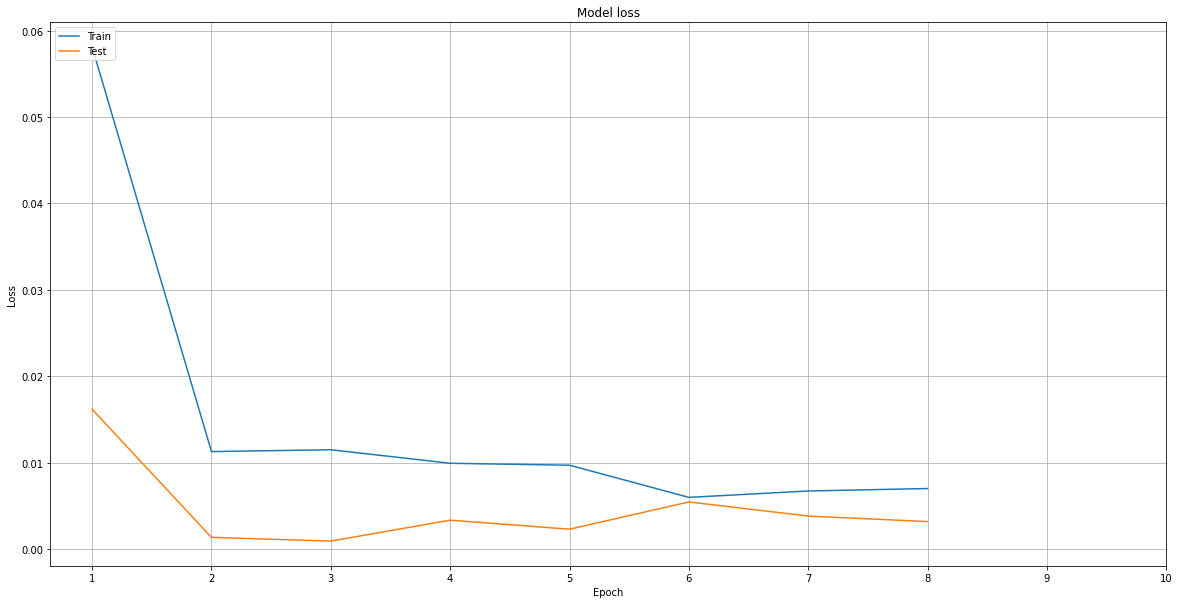

In [61]:
# Plot training & validation loss values
fig, ax = plt.subplots(figsize=(20, 10), sharex=True)
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])  
plt.title("Model loss")
plt.ylabel("Loss")
plt.xlabel("Epoch")
ax.xaxis.set_major_locator(plt.MaxNLocator(epochs))
plt.xticks(np.arange(10), np.arange(1, 11))
plt.legend(["Train", "Test"], loc="upper left")
plt.grid()
plt.show()

In [62]:
MAE_list =[]
MAPE_list=[]
MDAPE_list =[]


# Get the predicted values
model = load_model(path)  ### load model with lowest val_loss
y_pred_scaled = model.predict(x_test)

# Unscale the predicted values
y_pred = scaler_pred.inverse_transform(y_pred_scaled)
y_test_unscaled = scaler_pred.inverse_transform(y_test.reshape(-1, 1))

# Mean Absolute Error (MAE)
MAE = mean_absolute_error(y_test_unscaled, y_pred)
print(f'Median Absolute Error (MAE): {np.round(MAE, 2)}')
MAE_list.append(MAE)

# Mean Absolute Percentage Error (MAPE)
MAPE = np.mean((np.abs(np.subtract(y_test_unscaled, y_pred)/ y_test_unscaled))) * 100
print(f'Mean Absolute Percentage Error (MAPE): {np.round(MAPE, 2)} %')
MAPE_list.append(MAPE)

# Median Absolute Percentage Error (MDAPE)
MDAPE = np.median((np.abs(np.subtract(y_test_unscaled, y_pred)/ y_test_unscaled)) ) * 100
print(f'Median Absolute Percentage Error (MDAPE): {np.round(MDAPE, 2)} %')
MDAPE_list.append(MDAPE)

results = list(zip(MAE_list,MAPE_list, MDAPE_list))
results = pd.DataFrame(results,columns =['MAE','MAPE','MDAPE'])

# Add results to dictionary
results_dict['{}_{}dayshift_MAE_baseline'.format(ticker, shift)] = MAE_list
results_dict['{}_{}dayshift_MAPE_baseline'.format(ticker, shift)] = MAPE_list
results_dict['{}_{}dayshift_MDAPE_baseline'.format(ticker, shift)] = MDAPE_list

results

Median Absolute Error (MAE): 0.7
Mean Absolute Percentage Error (MAPE): 16.7 %
Median Absolute Percentage Error (MDAPE): 16.1 %


,MAE,MAPE,MDAPE
0,0.701074,16.695609,16.100447


In [63]:
# The date from which on the date is displayed
display_start_date = pd.Timestamp('today') - timedelta(days=438) #as of 10 April

# Add the date column
data_filtered_sub = data_filtered.copy()
data_filtered_sub['Date'] = df.date

# Add the difference between the valid and predicted prices
train = data_filtered_sub[:train_data_len + 1]
valid = data_filtered_sub[train_data_len:]
valid.insert(1, "Prediction", y_pred.ravel(), True)
valid.insert(1, "Difference", valid["Prediction"] - valid[dep_var[0]], True)

valid['Date'] = pd.to_datetime(valid['Date'])
train['Date'] = pd.to_datetime(train['Date'])

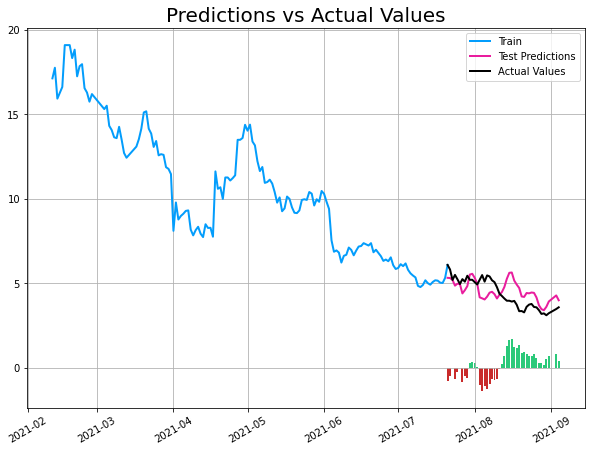

In [64]:
# Zoom in to a closer timeframe
valid = valid[valid['Date'] > display_start_date]
train = train[train['Date'] > display_start_date]

# Visualize the data
fig, ax1 = plt.subplots(figsize=(10, 7), sharex=True)
xt = train['Date']; yt = train[["Close"]]
xv = valid['Date']; yv = valid[["Close", "Prediction"]]
plt.title("Predictions vs Actual Values", fontsize=20)
plt.plot(xt, yt, color="#039dfc", linewidth=2.0)
plt.plot(xv, yv["Prediction"], color="#E91D9E", linewidth=2.0)
plt.plot(xv, yv["Close"], color="black", linewidth=2.0)
plt.legend(["Train", "Test Predictions", "Actual Values"], loc="bottom left")

# # Create the bar plot with the differences
x = valid['Date']
y = valid["Difference"]

# Create custom color range for positive and negative differences
valid.loc[y >= 0, 'diff_color'] = "#2BC97A"
valid.loc[y < 0, 'diff_color'] = "#C92B2B"

plt.bar(x, y, width=0.8, color=valid['diff_color'])
plt.xticks(rotation = 30)

plt.grid()
plt.show()

## Overall Results

In [65]:
results_df =pd.DataFrame.from_dict(results_dict).transpose().reset_index()
results_df['ticker'] = results_df['index'].str.split('_').str[0]
results_df['shift'] = results_df['index'].str.split('_').str[1]
results_df['metric'] = results_df['index'].str.split('_').str[2]
results_df['scenario'] = results_df['index'].str.split('_').str[3]
results_df['scenario'].fillna(value = 'sentiment', inplace = True)
results_df['results_%'] = results_df[0]
results_df.drop(['index', 0], axis = 1, inplace = True)
results_df.sort_values(['metric', 'shift','scenario'], inplace = True)
results_df = results_df.pivot(index = ['shift', 'metric'], columns = 'scenario', values = 'results_%').reset_index()
results_df

scenario,shift,metric,baseline,sentiment
0,1dayshift,MAE,0.669070,0.566040
1,1dayshift,MAPE,14.802798,12.112776
2,1dayshift,MDAPE,14.332253,9.162957
3,4dayshift,MAE,0.796168,0.698825
4,4dayshift,MAPE,17.954730,15.515019
5,4dayshift,MDAPE,17.839609,11.433386
6,7dayshift,MAE,0.701074,0.646756
7,7dayshift,MAPE,16.695609,14.637375
8,7dayshift,MDAPE,16.100447,11.855586


In [66]:
results_df.to_csv('{}_LSTM.csv'.format(ticker), index = False)